In [76]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt 

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image 

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from pathlib import Path

from nltools.stats import fdr

from sklearn.metrics import confusion_matrix

import joblib
import numpy as np
from pathlib import Path

In [2]:
#import data set
df_rest = pd.read_csv("/home/xlajoie/Desktop/Final_restricted.csv")

df_unrest = pd.read_csv("/home/xlajoie/Desktop/Final_unrestricted.csv")


Final_df = pd.merge(df_rest, 
                      df_unrest, 
                      on ='Subject', 
                      how ='inner')
Final_df

,Subject,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,Race,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,White,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,White,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,Black or African Am.,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,101309,29,True,NotTwin,,52385_82248,52385,82248,NaN,Black or African Am.,...,5.2,122.25,110.45,0.0,38.6,106.39,104.39,1.80,0.0,1.80
4,102008,24,True,NotTwin,,52018_81882,52018,81882,NaN,White,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,990366,22,True,MZ,,56064_85885,56064,85885,NaN,White,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
670,991267,30,True,NotTwin,,51639_81503,51639,81503,NaN,White,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
671,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,White,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
672,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,White,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [3]:
# Filter left-handers (include >=50 handedness) 
Final_df = Final_df[Final_df["Handedness"] >= 50].reset_index()

# transform M and F with 0 and 1 
Final_df.rename(columns={"Subject": "subject_label"}, inplace=True)
Final_df["Gender"] = Final_df["Gender"].replace({"M": 0, "F": 1})
Final_df

,index,subject_label,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,0,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,1,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,2,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,4,102008,24,True,NotTwin,,52018_81882,52018,81882,NaN,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
4,7,102513,30,True,NotTwin,,56077_85897,56077,85897,NaN,...,5.2,108.79,98.04,2.0,54.3,84.07,82.37,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,669,990366,22,True,MZ,,56064_85885,56064,85885,NaN,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
566,670,991267,30,True,NotTwin,,51639_81503,51639,81503,NaN,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
567,671,992673,33,True,NotTwin,,56143_85963,56143,85963,NaN,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
568,672,993675,29,True,NotTwin,,55800_85621,55800,85621,NaN,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [4]:
print("hommes = ", Final_df["Gender"].value_counts()[0])
print("femmes = ", Final_df["Gender"].value_counts()[1])

hommes =  264
femmes =  306


In [5]:
#save new csv with modifications as "final hcp database"
Final_df.to_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [6]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

# Classification et trouver seed region qui donnent une meilleure classification

In [7]:
def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(8, -1) # 8
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn

In [85]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    
    See also nltools summarized_bootstrap function: https://nltools.org/_modules/nltools/stats.html
    """
    mean_scores = np.mean(boot_coefs, axis=0)
    z_scores = np.mean(boot_coefs, axis=0)/np.std(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), pval, 0)
    #boot_z_fdr = np.where(pval < fdr(pval, q=0.05), pval, 0)
    
    return mean_scores, z_scores, pval, pval_bonf#, boot_z_fdr

In [9]:
def machine_learning(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

In [71]:
def machine_learning_logistic(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LogisticRegression(random_state = 123)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of

In [72]:
def run_logistic(df_boot, data, seed):

    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_boot)
    subject_label = df_boot["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_boot["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning_logistic(x_correl, y_sex)

    return x_correl, coef

In [10]:
def run(df_boot, data, seed):
    df_bootstrap = pd.DataFrame()
    for j in range(0, len(df_boot)):
        index = random.randint(0, len(df_boot)-1)
        frames = [df_bootstrap, df_boot[index:index+1]]
        df_bootstrap = pd.concat(frames)

    df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)


    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_bootstrap)
    subject_label = df_bootstrap["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_bootstrap["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning(x_correl, y_sex)

    return x_correl

In [11]:
def regionsOfInterest(accuracy, pvalue, moyenne, rois, label, x_correl):
    pvalue_val = pvalue.reshape(len(rois), 148).T
    pvalue_uncorrected = pvalue_val < 0.05

    data_pval_uncorrected = pd.DataFrame(pvalue_uncorrected, columns=rois)
    data_pval = pd.DataFrame(pvalue_val, columns=rois)

    pval_corrected = np.multiply(pvalue_val, pvalue_uncorrected)
    
    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)

    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)
    
    weighted_tab = pd.DataFrame(weighted_coef, columns=["coefficient"])
    weighted_tab['seed'] = seed_name
    weighted_tab['labels'] = label_name
    
    # print the 10 best seed anf their labels
    print(weighted_tab.sort_values(by=['coefficient'], ascending=False).head(10))
    
    
    weighted_coef[weighted_coef<0.054609] = 0 # maybe changed the 0.054609 for a variable
        
    
    # printing the accuracy and its interval of confidance
    acc_test = np.asarray(accuracy)
    moy = np.mean(acc_test)
    se = np.std(acc_test)
    lower = moy - (1.96 * se)
    upper = moy + (1.96 * se)
    print("The mean accuracy : " + str(moy))
    print("The standard deviation of the accuracy : " + str(se))
    print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
    print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
    
    return weighted_tab

True

In [36]:
def bestRegion(ROIs):
    
    best = ROIs.sort_values(by=['coefficient'], ascending=False).head(10)
    best_roi = []

    for row in best.iterrows():
        best_roi.append([row[1][1], row[1][2], [], []])

    label_female = []
    label_male = []

    for i in range(0,len(Final_df["Gender"])):
        if Final_df["Gender"][i] == 0:
            label_male.append(Final_df["subject_label"][i])

        elif Final_df["Gender"][i] == 1:
            label_female.append(Final_df["subject_label"][i])


    for i in data.keys():
        if label_male.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][2].append(data[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]]) 

        elif label_female.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][3].append(data[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

    for i in range(0, len(best_roi)):
        best_roi[i][2] = np.asarray(best_roi[i][2]) # male
        best_roi[i][3] = np.asarray(best_roi[i][3]) # female
        plt.boxplot([best_roi[i][2], best_roi[i][3]])
        plt.title(best_roi[i][0]+" "+best_roi[i][1])
        plt.show()

## Single run with all seed

In [12]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [140]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_seed-{seed_name}_mean-4_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)
        

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 570/570 [06:14<00:00,  1.52it/s]


In [19]:
run_1 = run(df, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 529396.21it/s]


train: 456 test: 114
[array([0.89130435, 0.97826087, 0.91304348, 0.84782609, 0.97826087,
       0.89130435, 0.84444444, 0.93333333, 0.88888889, 0.95555556])]
predicted class  Femme  Homme
actual class                 
Femme               58      4
Homme                6     46
accuracy test (r2) = 0.9122807017543859
accuracy train (r2) = 1.0


## Bootstrap result all seed, single seed, all left seed and all right seed

In [117]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results" / "models_iteration-10000_seeds-all_pickle.pkl"
results_path_aMTG_L = study_dir / "results" / "models_iteration-10000_seeds-aMTG_L.pkl"
results_path_aMTG_R = study_dir / "results" / "models_iteration-10000_seeds-aMTG_R.pkl"
results_path_opIFG_L = study_dir / "results" / "models_iteration-10000_seeds-opIFG_L.pkl"
results_path_opIFG_R = study_dir / "results" / "models_iteration-10000_seeds-opIFG_R.pkl"
results_path_pITG_L = study_dir / "results" / "models_iteration-10000_seeds-pITG_L.pkl"
results_path_pITG_R = study_dir / "results" / "models_iteration-10000_seeds-pITG_R.pkl"
results_path_planumtemp_L = study_dir / "results" / "models_iteration-10000_seeds-planumtemp_L.pkl"
results_path_planumtemp_R = study_dir / "results" / "models_iteration-10000_seeds-planumtemp_R.pkl"
results_path_all_left = study_dir / "results" / "models_iteration-10000_seeds-left.pkl"
results_path_all_right = study_dir / "results" / "models_iteration-10000_seeds-right.pkl"



results = joblib.load(results_path_all_seed)

coefs = []
for result in results:
    coefs.append(result["model"].coef_[0])

coefs = np.array(coefs)

data_results = pd.DataFrame.from_dict(results)
moyenne, scoresZ, pvalue, pvalue_bonf = bootstrap_scores(coefs)
moyenne.shape

[0.77920132 0.93278182 0.41968771 ... 0.86705264 0.3918883  0.71360611]


(1184,)

In [37]:
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
label = atlas_dest["labels"].drop([0,42,117]) # correction for the destrieux atlas labels
label = label.reset_index()

## Best regions for all seeds

      coefficient          seed                    labels
959      0.016141        aMTG_R          L S_temporal_inf
453      0.015930        pITG_L   L G_cingul-Post-ventral
866      0.014635  planumtemp_R          R S_front_middle
598      0.014404       opIFG_R  L G_and_S_cingul-Mid-Ant
1014     0.014371        aMTG_R          R S_front_middle
900      0.012792        aMTG_R     L G_front_inf-Orbital
1012     0.012738        aMTG_R    R S_collat_transv_post
1002     0.012191        aMTG_R            R Lat_Fis-post
923      0.011730        aMTG_R   L G_temp_sup-Plan_tempo
983      0.011674        aMTG_R   R G_oc-temp_med-Lingual
The mean accuracy : 0.8756353982300885
The standard deviation of the accuracy : 0.032657349067499834
The lower boundry of the confidance interval of the accuracy : 0.8116269940577888
The upper boundry of the confidance interval of the accuracy : 0.9396438024023882


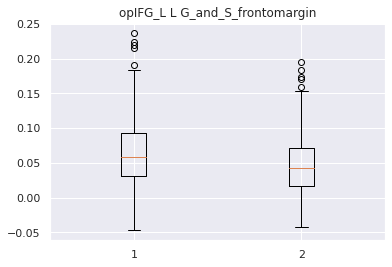

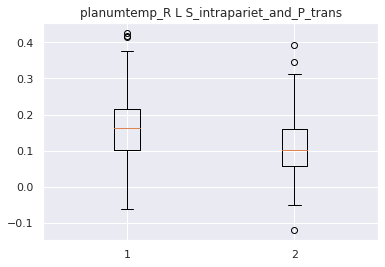

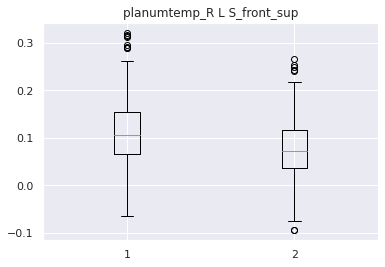

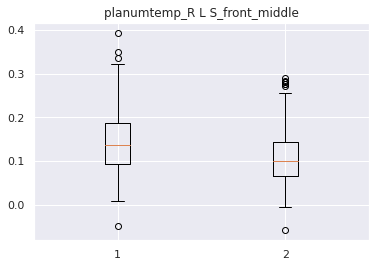

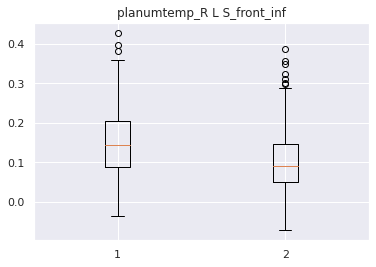

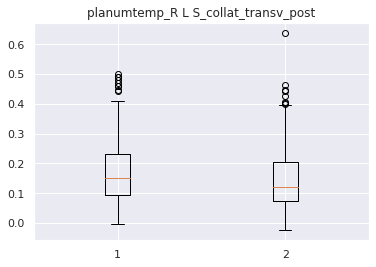

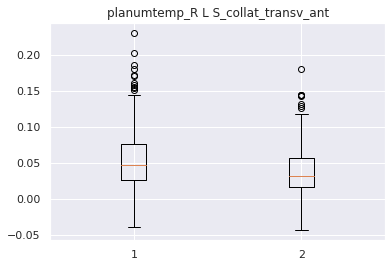

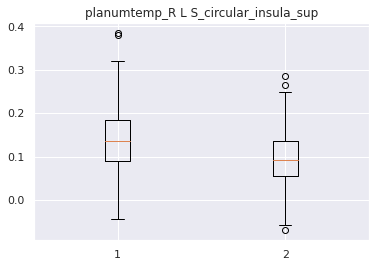

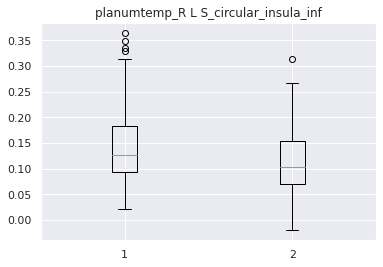

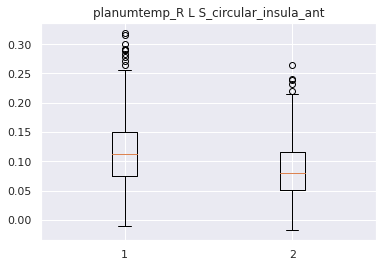

In [39]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for aMTG_L

     coefficient    seed                       labels
8       0.105448  aMTG_L       L G_cingul-Post-dorsal
55      0.097869  aMTG_L  L S_intrapariet_and_P_trans
52      0.097440  aMTG_L             L S_front_middle
118     0.089456  aMTG_L                  R S_central
112     0.082334  aMTG_L       R Lat_Fis-ant-Horizont
68      0.072343  aMTG_L      L S_precentral-sup-part
3       0.071027  aMTG_L         L G_and_S_subcentral
147     0.069196  aMTG_L      R S_temporal_transverse
66      0.069180  aMTG_L              L S_postcentral
98      0.068397  aMTG_L       R G_pariet_inf-Angular
The mean accuracy : 0.7708300884955753
The standard deviation of the accuracy : 0.042084857312028094
The lower boundry of the confidance interval of the accuracy : 0.6883437681640002
The upper boundry of the confidance interval of the accuracy : 0.8533164088271504


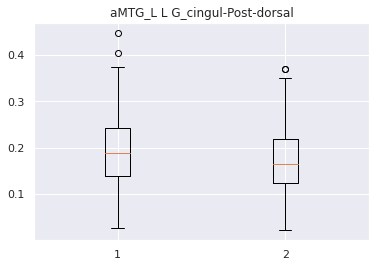

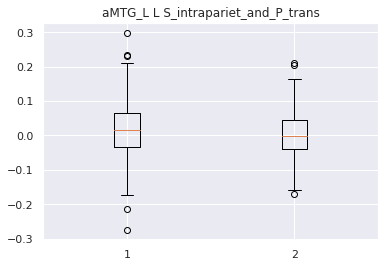

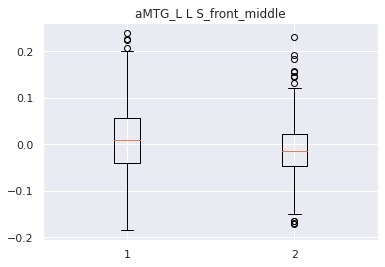

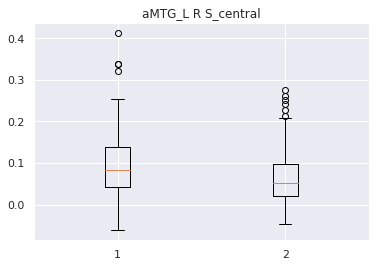

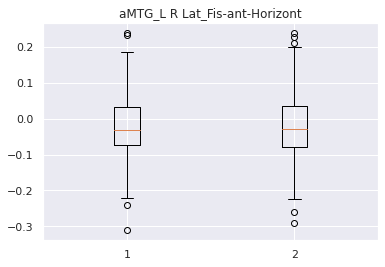

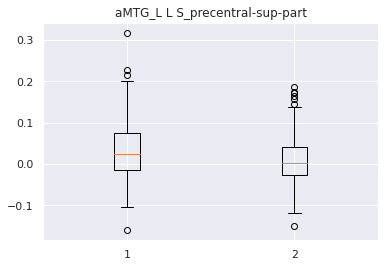

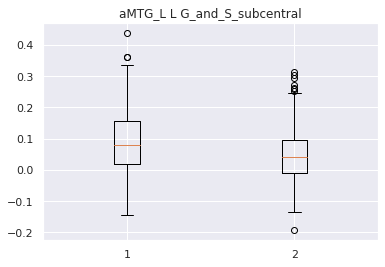

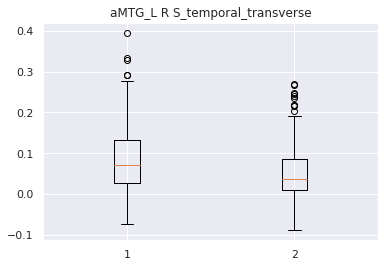

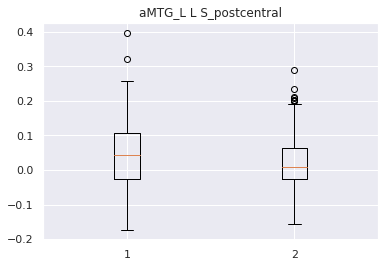

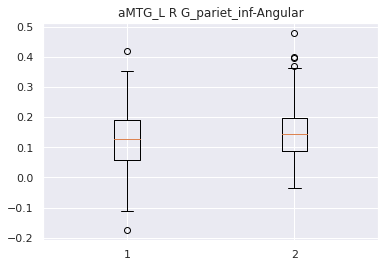

In [42]:
rois = ["aMTG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for aMTG_R

     coefficient    seed                      labels
29      0.114459  aMTG_R               L G_precuneus
62      0.108896  aMTG_R      L S_orbital_med-olfact
35      0.100799  aMTG_R     L G_temp_sup-Plan_tempo
18      0.099887  aMTG_R        L G_occipital_middle
12      0.096599  aMTG_R       L G_front_inf-Orbital
90      0.090152  aMTG_R   R G_Ins_lg_and_S_cent_ins
14      0.085040  aMTG_R            L G_front_middle
84      0.082616  aMTG_R                  R G_cuneus
131     0.075406  aMTG_R  R S_oc_sup_and_transversal
89      0.073947  aMTG_R               R G_front_sup
The mean accuracy : 0.8310061946902655
The standard deviation of the accuracy : 0.038471487031740706
The lower boundry of the confidance interval of the accuracy : 0.7556020801080537
The upper boundry of the confidance interval of the accuracy : 0.9064103092724772


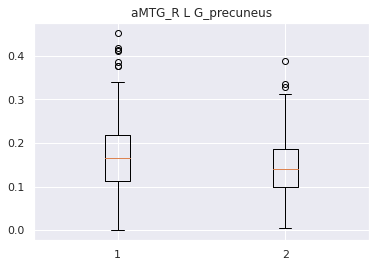

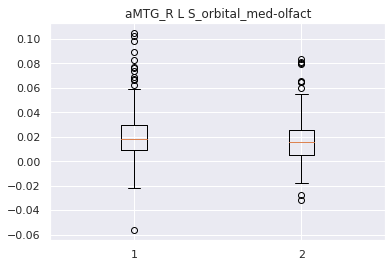

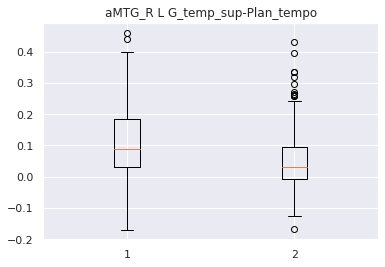

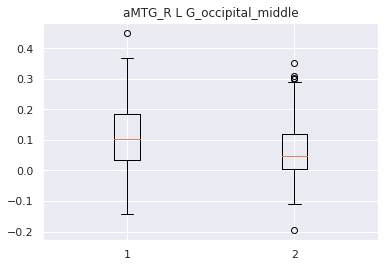

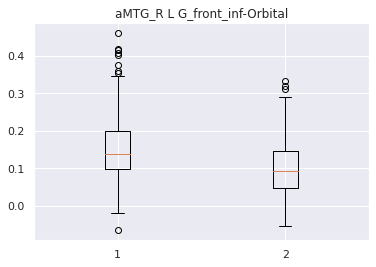

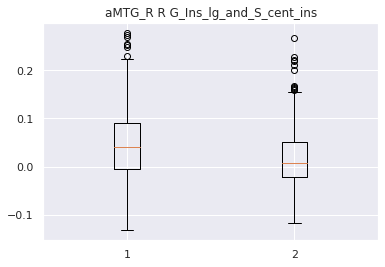

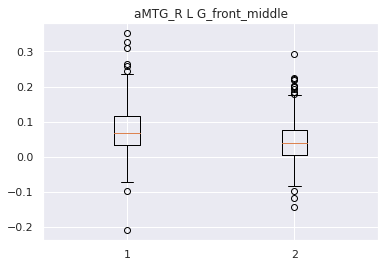

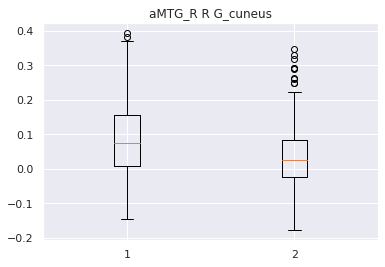

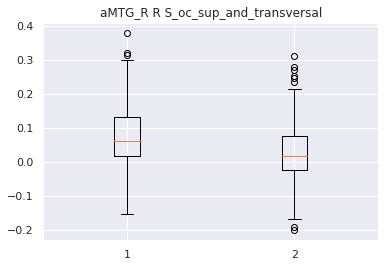

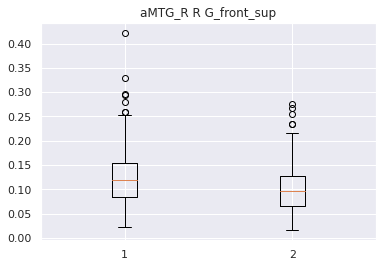

In [44]:
rois = ["aMTG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for opIFG_L

     coefficient     seed                     labels
112     0.101409  opIFG_L     R Lat_Fis-ant-Horizont
97      0.095263  opIFG_L                R G_orbital
45      0.081348  opIFG_L      L S_cingul-Marginalis
43      0.081019  opIFG_L              L S_calcarine
123     0.081018  opIFG_L      R S_collat_transv_ant
118     0.080594  opIFG_L                R S_central
86      0.075656  opIFG_L      R G_front_inf-Orbital
22      0.075643  opIFG_L    L G_oc-temp_med-Parahip
17      0.074238  opIFG_L          L G_insular_short
56      0.073638  opIFG_L  L S_oc_middle_and_Lunatus
The mean accuracy : 0.7546575221238938
The standard deviation of the accuracy : 0.04247156877029631
The lower boundry of the confidance interval of the accuracy : 0.671413247334113
The upper boundry of the confidance interval of the accuracy : 0.8379017969136746


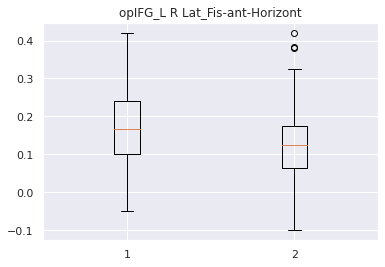

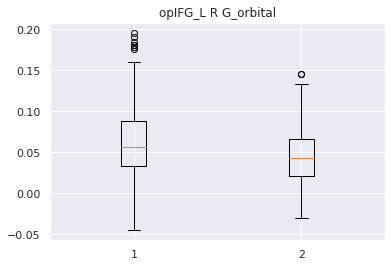

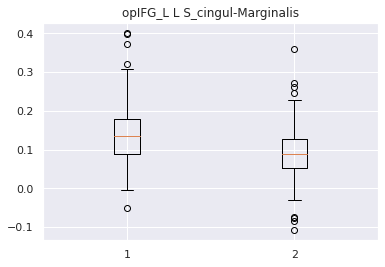

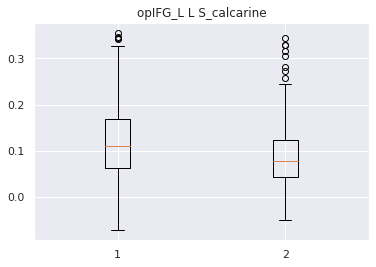

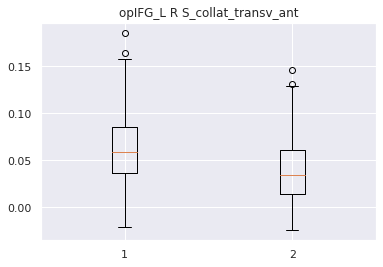

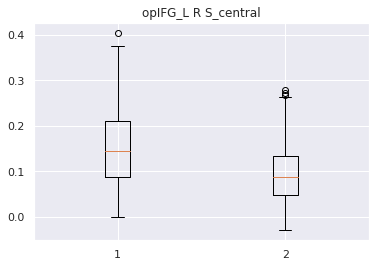

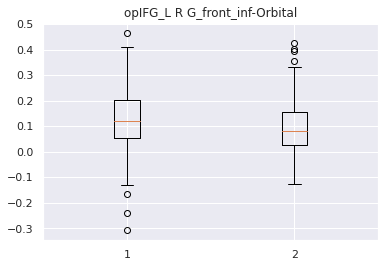

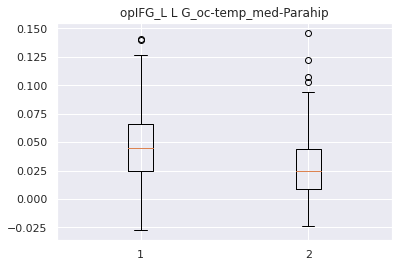

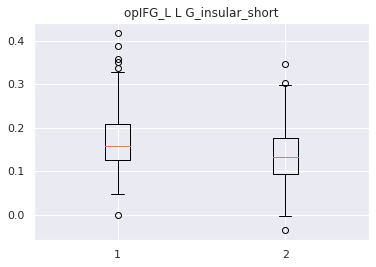

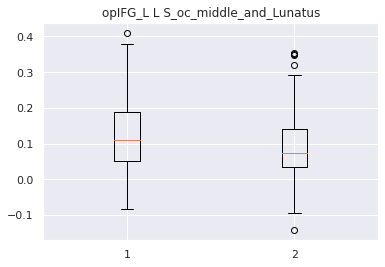

In [46]:
rois = ["opIFG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for opIFG_R

     coefficient     seed                      labels
136     0.172777  opIFG_R      R S_orbital_med-olfact
6       0.123589  opIFG_R    L G_and_S_cingul-Mid-Ant
44      0.122687  opIFG_R                 L S_central
135     0.119384  opIFG_R         R S_orbital_lateral
62      0.103873  opIFG_R      L S_orbital_med-olfact
124     0.089680  opIFG_R      R S_collat_transv_post
74      0.081115  opIFG_R      R G_and_S_frontomargin
89      0.077964  opIFG_R               R G_front_sup
76      0.075539  opIFG_R       R G_and_S_paracentral
131     0.071128  opIFG_R  R S_oc_sup_and_transversal
The mean accuracy : 0.794267256637168
The standard deviation of the accuracy : 0.04018283373369482
The lower boundry of the confidance interval of the accuracy : 0.7155089025191261
The upper boundry of the confidance interval of the accuracy : 0.8730256107552099


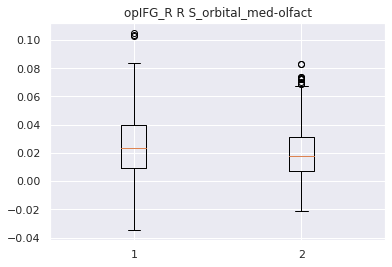

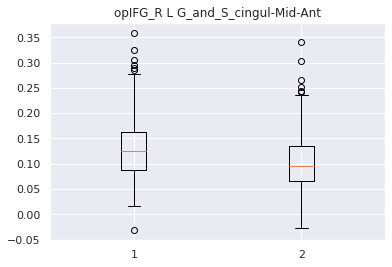

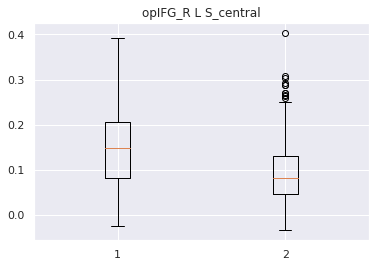

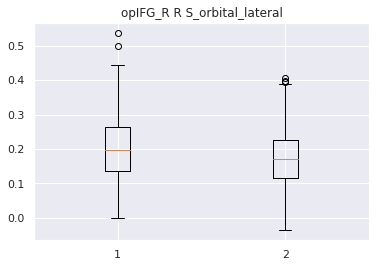

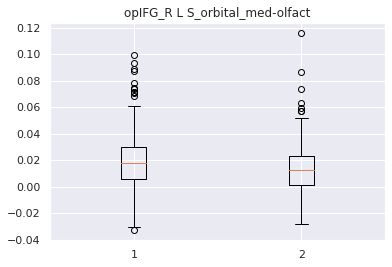

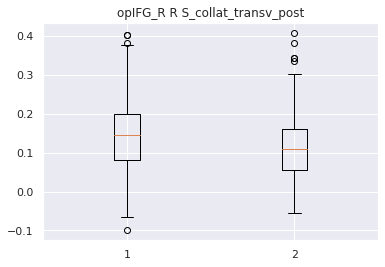

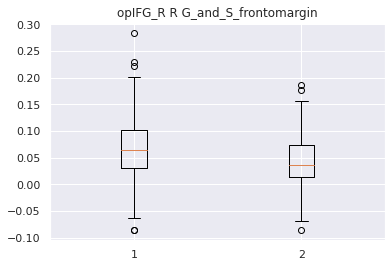

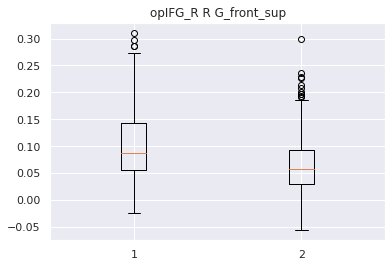

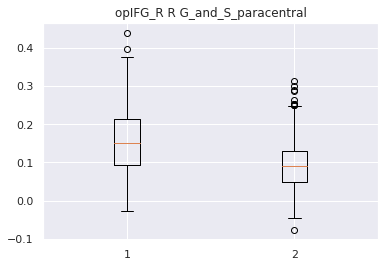

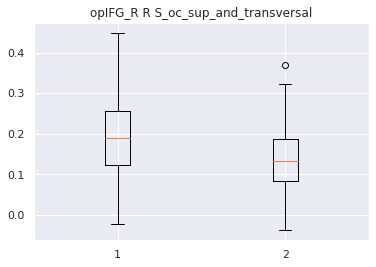

In [48]:
rois = ["opIFG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for pITG_L

     coefficient    seed                   labels
84      0.118773  pITG_L               R G_cuneus
51      0.098987  pITG_L            L S_front_inf
20      0.086198  pITG_L  L G_oc-temp_lat-fusifor
46      0.082773  pITG_L  L S_circular_insula_ant
32      0.080489  pITG_L  L G_temp_sup-G_T_transv
62      0.076383  pITG_L   L S_orbital_med-olfact
102     0.076056  pITG_L           R G_precentral
141     0.075259  pITG_L  R S_precentral-inf-part
110     0.075118  pITG_L         R G_temporal_inf
68      0.066607  pITG_L  L S_precentral-sup-part
The mean accuracy : 0.7689061946902653
The standard deviation of the accuracy : 0.04198785857645238
The lower boundry of the confidance interval of the accuracy : 0.6866099918804187
The upper boundry of the confidance interval of the accuracy : 0.851202397500112


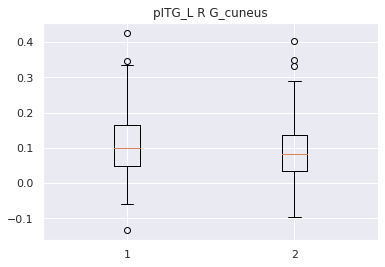

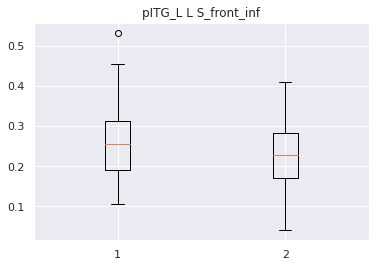

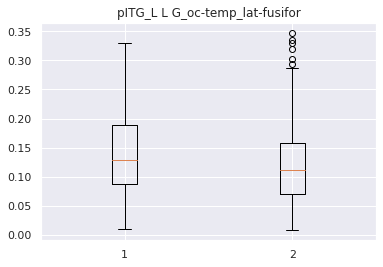

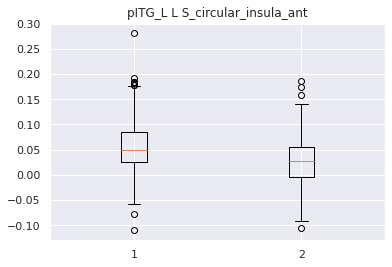

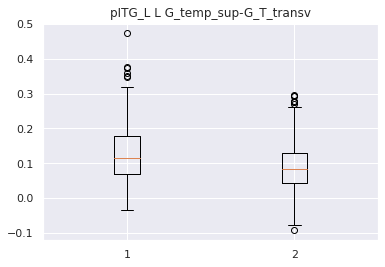

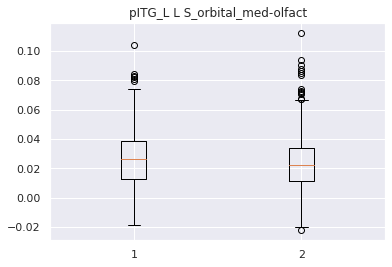

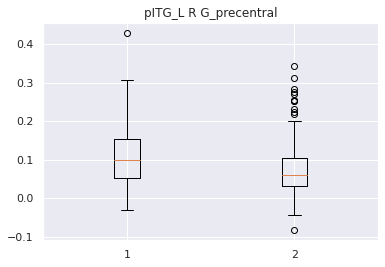

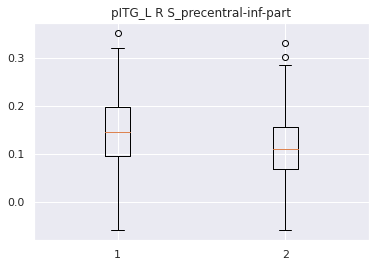

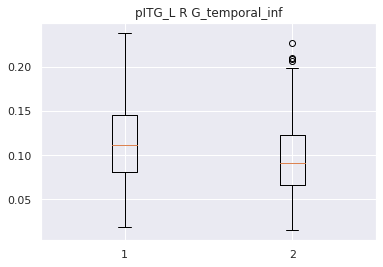

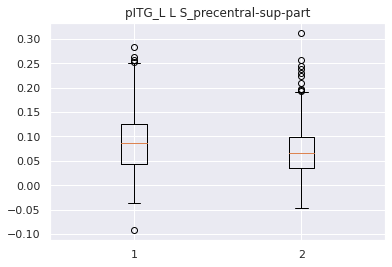

In [50]:
rois = ["pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for pITG_R

     coefficient    seed                   labels
139     0.120759  pITG_R         R S_pericallosal
10      0.102443  pITG_R               L G_cuneus
110     0.100556  pITG_R         R G_temporal_inf
118     0.071962  pITG_R              R S_central
47      0.067741  pITG_R  L S_circular_insula_inf
62      0.066593  pITG_R   L S_orbital_med-olfact
28      0.064771  pITG_R           L G_precentral
15      0.058307  pITG_R            L G_front_sup
76      0.057538  pITG_R    R G_and_S_paracentral
126     0.054904  pITG_R         R S_front_middle
The mean accuracy : 0.7033247787610619
The standard deviation of the accuracy : 0.04607281375305292
The lower boundry of the confidance interval of the accuracy : 0.6130220638050782
The upper boundry of the confidance interval of the accuracy : 0.7936274937170457


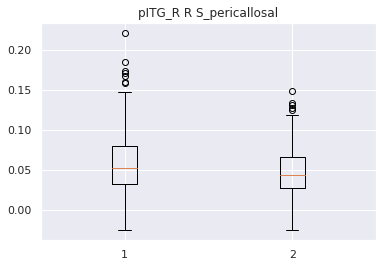

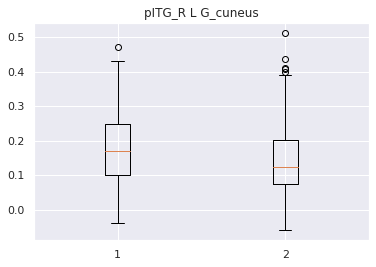

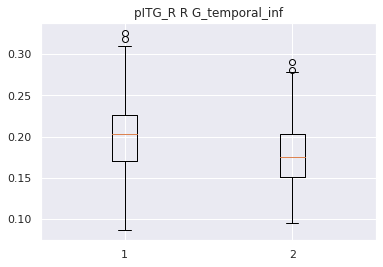

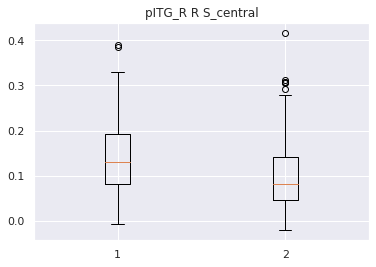

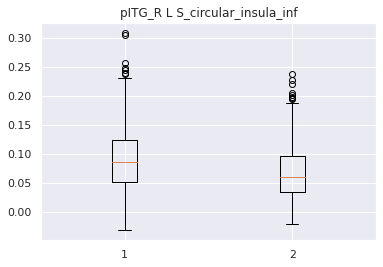

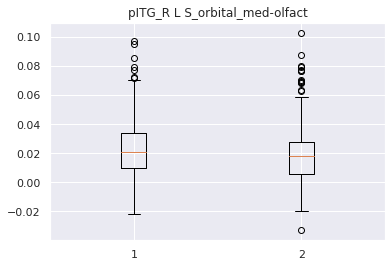

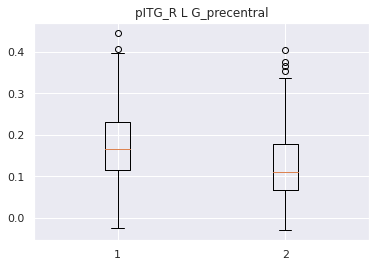

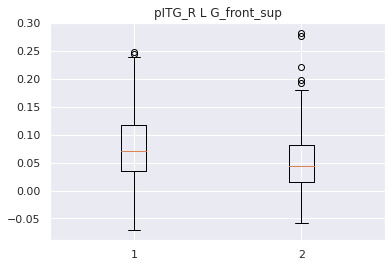

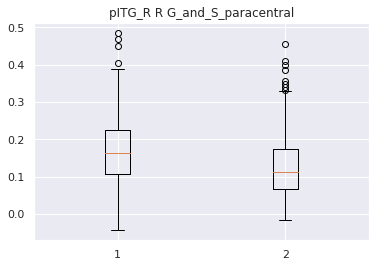

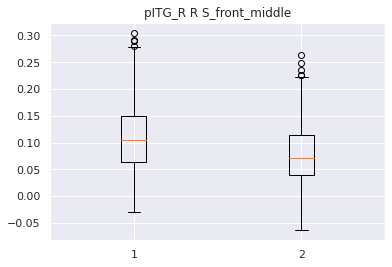

In [52]:
rois = ["pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for planumtemp_L

     coefficient          seed                       labels
35      0.156935  planumtemp_L      L G_temp_sup-Plan_tempo
15      0.100201  planumtemp_L                L G_front_sup
66      0.094894  planumtemp_L              L S_postcentral
22      0.091087  planumtemp_L      L G_oc-temp_med-Parahip
43      0.089205  planumtemp_L                L S_calcarine
87      0.083953  planumtemp_L       R G_front_inf-Triangul
141     0.081410  planumtemp_L      R S_precentral-inf-part
92      0.074406  planumtemp_L         R G_occipital_middle
46      0.072722  planumtemp_L      L S_circular_insula_ant
55      0.071155  planumtemp_L  L S_intrapariet_and_P_trans
The mean accuracy : 0.7697318584070796
The standard deviation of the accuracy : 0.04184230256720604
The lower boundry of the confidance interval of the accuracy : 0.6877209453753558
The upper boundry of the confidance interval of the accuracy : 0.8517427714388034


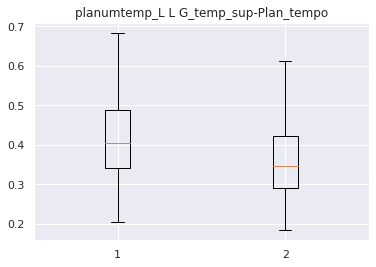

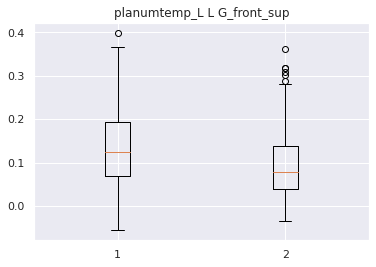

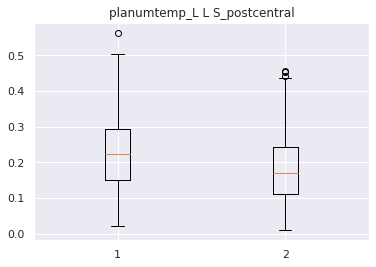

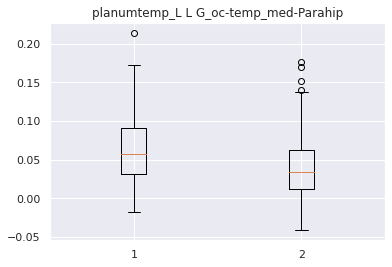

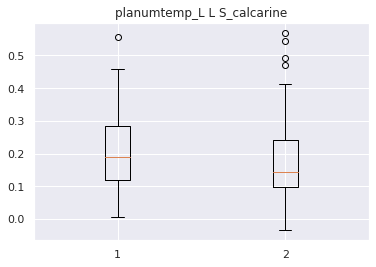

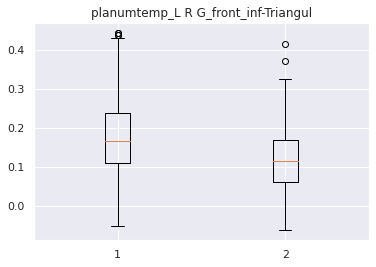

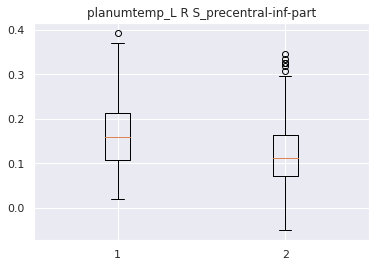

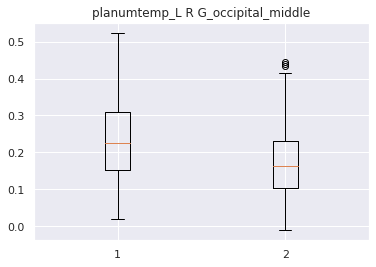

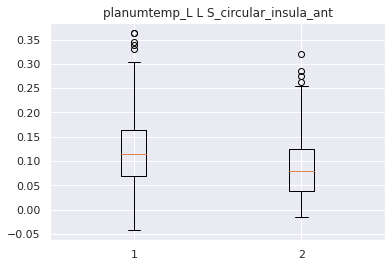

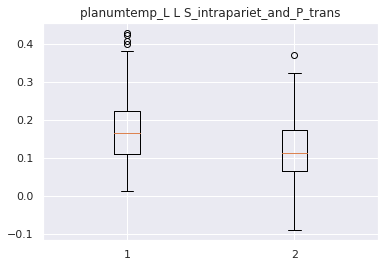

In [54]:
rois = ["planumtemp_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for planumtemp_R

     coefficient          seed                     labels
46      0.117693  planumtemp_R    L S_circular_insula_ant
126     0.116896  planumtemp_R           R S_front_middle
128     0.092035  planumtemp_R     R S_interm_prim-Jensen
70      0.086408  planumtemp_R            L S_subparietal
82      0.085125  planumtemp_R     R G_cingul-Post-dorsal
116     0.084875  planumtemp_R            R Pole_temporal
109     0.084691  planumtemp_R    R G_temp_sup-Plan_tempo
10      0.084342  planumtemp_R                 L G_cuneus
130     0.069217  planumtemp_R  R S_oc_middle_and_Lunatus
101     0.067885  planumtemp_R            R G_postcentral
The mean accuracy : 0.805538053097345
The standard deviation of the accuracy : 0.039442364064715345
The lower boundry of the confidance interval of the accuracy : 0.728231019530503
The upper boundry of the confidance interval of the accuracy : 0.8828450866641872


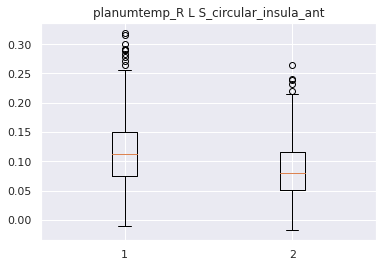

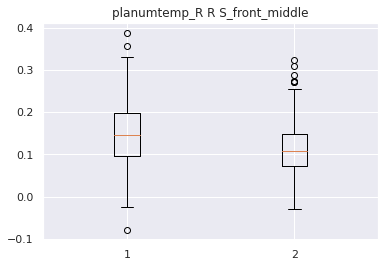

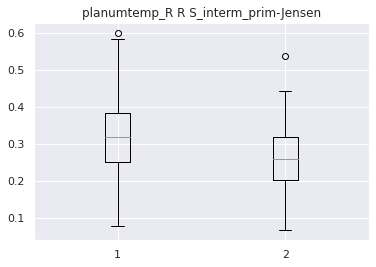

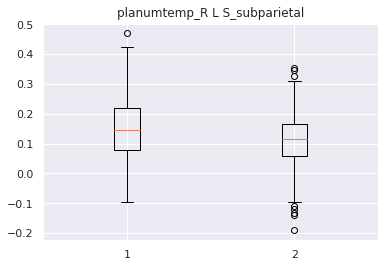

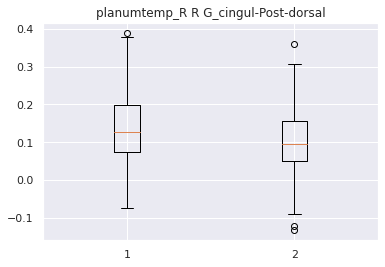

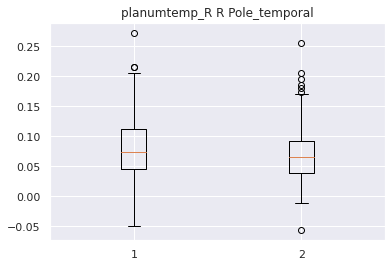

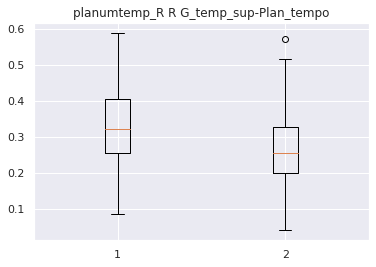

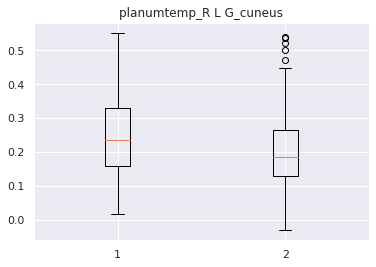

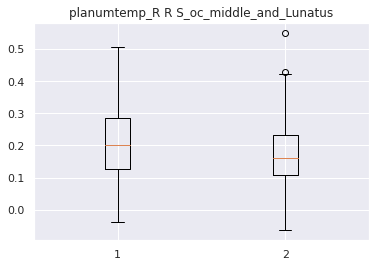

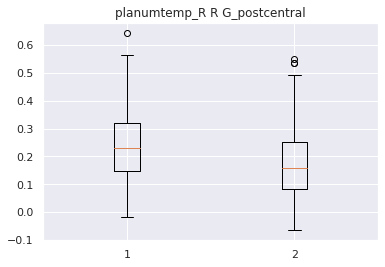

In [56]:
rois = ["planumtemp_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for all left seed

     coefficient          seed                       labels
453     0.038098        pITG_L      L G_cingul-Post-ventral
86      0.030980       opIFG_L        R G_front_inf-Orbital
348     0.030789        aMTG_L             L S_front_middle
4       0.029461       opIFG_L   L G_and_S_transv_frontopol
439     0.027195        aMTG_L               R S_suborbital
63      0.026924       opIFG_L         L S_orbital-H_Shaped
504     0.025827        pITG_L  L S_oc-temp_med_and_Lingual
246     0.024975  planumtemp_L       R G_pariet_inf-Angular
45      0.024690       opIFG_L        L S_cingul-Marginalis
464     0.024227        pITG_L      L G_oc-temp_lat-fusifor
The mean accuracy : 0.8520902654867257
The standard deviation of the accuracy : 0.035654700939918765
The lower boundry of the confidance interval of the accuracy : 0.782207051644485
The upper boundry of the confidance interval of the accuracy : 0.9219734793289664


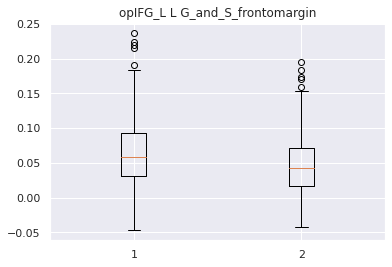

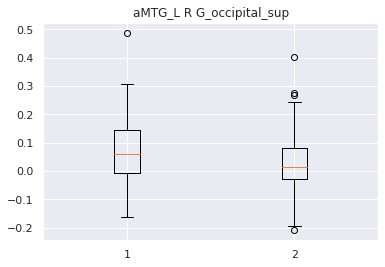

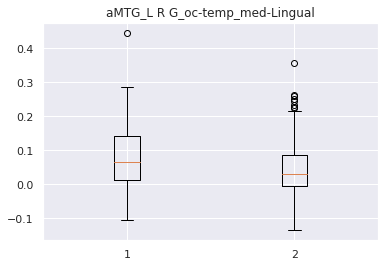

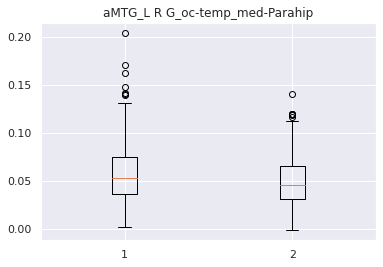

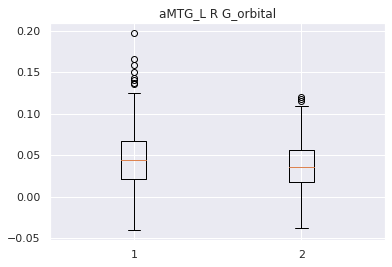

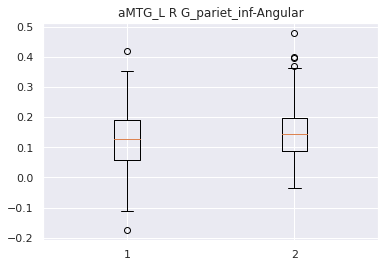

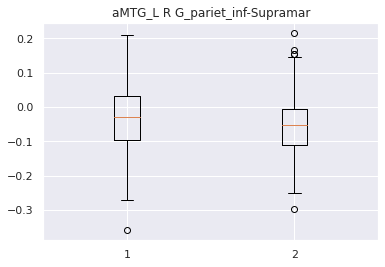

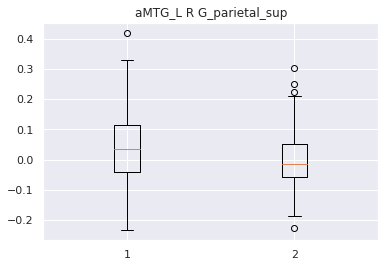

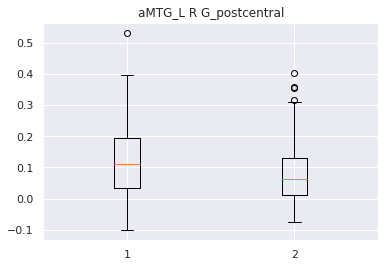

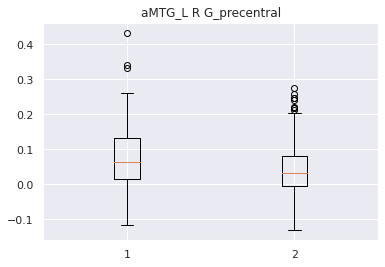

In [58]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for all right seed

     coefficient          seed                    labels
367     0.035239        aMTG_R          L S_temporal_inf
6       0.034612       opIFG_R  L G_and_S_cingul-Mid-Ant
308     0.034158        aMTG_R     L G_front_inf-Orbital
302     0.027601        aMTG_R  L G_and_S_cingul-Mid-Ant
420     0.027219        aMTG_R    R S_collat_transv_post
331     0.026183        aMTG_R   L G_temp_sup-Plan_tempo
274     0.025900  planumtemp_R          R S_front_middle
385     0.025784        aMTG_R             R G_front_sup
314     0.025591        aMTG_R      L G_occipital_middle
410     0.025531        aMTG_R            R Lat_Fis-post
The mean accuracy : 0.8846327433628319
The standard deviation of the accuracy : 0.03203755890381336
The lower boundry of the confidance interval of the accuracy : 0.8218391279113577
The upper boundry of the confidance interval of the accuracy : 0.9474263588143061


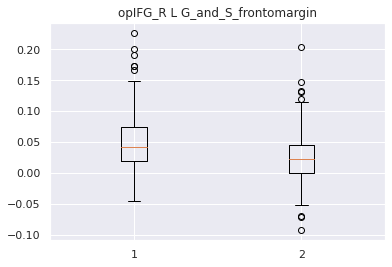

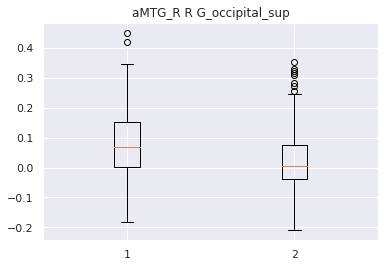

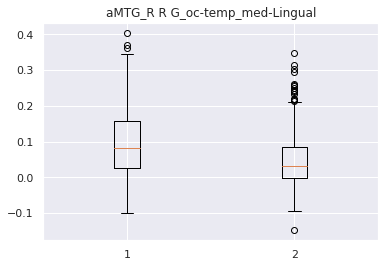

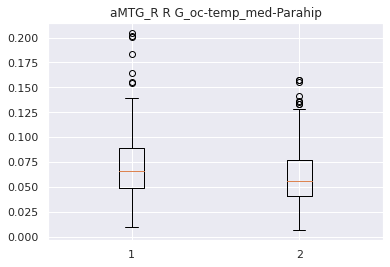

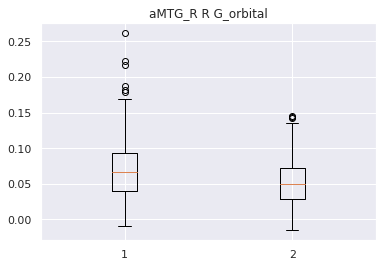

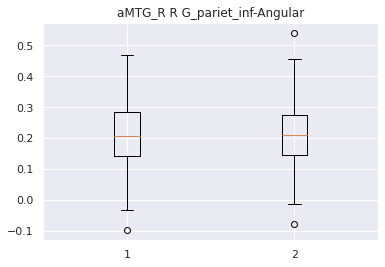

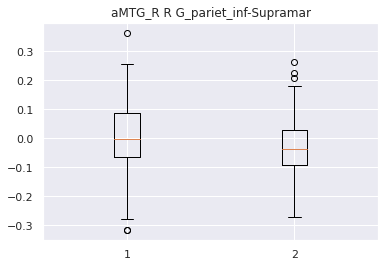

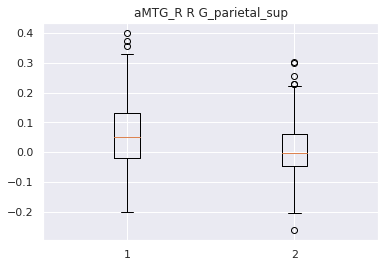

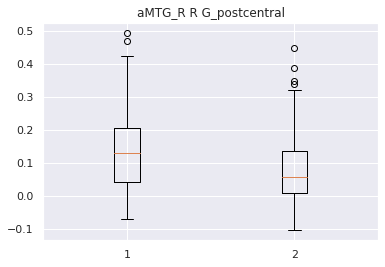

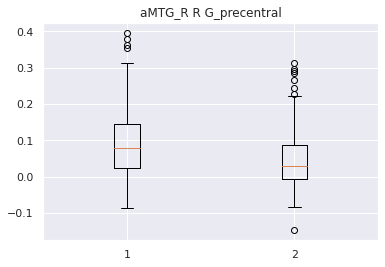

In [60]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

# Logistic regression

In [77]:
[x_correl_logi, coef_logi] = run_logistic(df_boot, data, SEEDS)

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 222789.42it/s]


train: 456 test: 114
[array([0.80434783, 0.86956522, 0.76086957, 0.82608696, 0.89130435,
       0.80434783, 0.84444444, 0.8       , 0.86666667, 0.73333333])]
predicted class  Femme  Homme
actual class                 
Femme               50     11
Homme                9     44
accuracy test (r2) = 0.8245614035087719
accuracy train (r2) = 0.9342105263157895


In [131]:
boot_coefs = (coef_logi["model"].coef_[0])

moyenne_logi = np.mean(boot_coefs, axis=0)
scoresZ_logi = (boot_coefs - moyenne_logi)/np.std(boot_coefs, axis=0)
assert np.sum(np.isnan(scoresZ_logi)) == 0
pvalue_logi = 2 * (1 - stats.norm.cdf(np.abs(scoresZ_logi)))

## Best region for all seed

      coefficient     seed                      labels
394      0.097708   aMTG_L      R G_pariet_inf-Angular
453      0.094681   pITG_L     L G_cingul-Post-ventral
300      0.090741   aMTG_L  L G_and_S_transv_frontopol
431      0.086681   aMTG_L         R S_orbital_lateral
41       0.082606  opIFG_L            L Pole_occipital
527      0.079535   pITG_L     R G_cingul-Post-ventral
1056     0.074773   pITG_R     L G_oc-temp_lat-fusifor
510      0.074410   pITG_L             L S_postcentral
349      0.074286   aMTG_L               L S_front_sup
374      0.071824   aMTG_L  R G_and_S_transv_frontopol
The mean accuracy : 0.8245614035087719
The standard deviation of the accuracy : 0.0
The lower boundry of the confidance interval of the accuracy : 0.8245614035087719
The upper boundry of the confidance interval of the accuracy : 0.8245614035087719


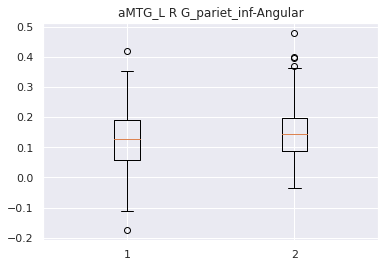

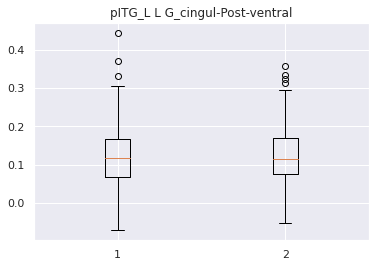

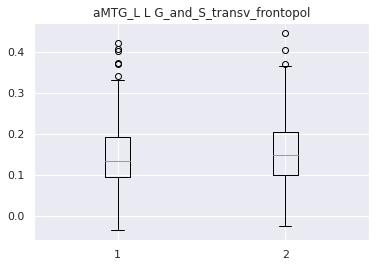

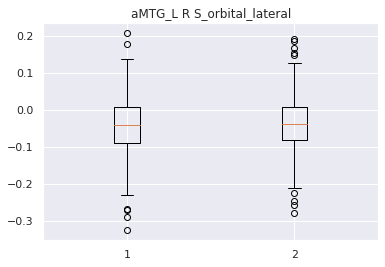

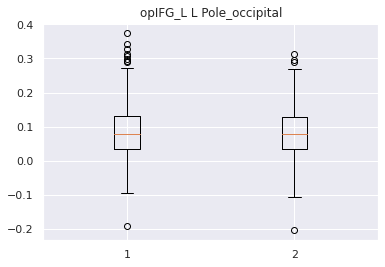

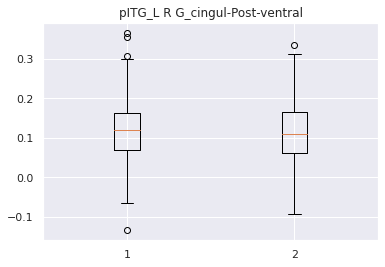

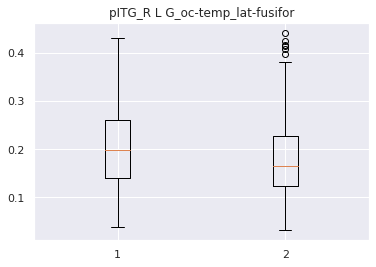

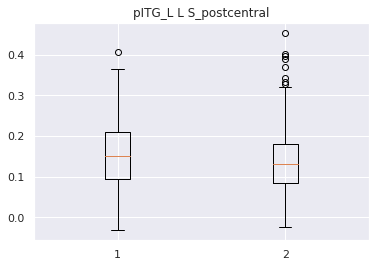

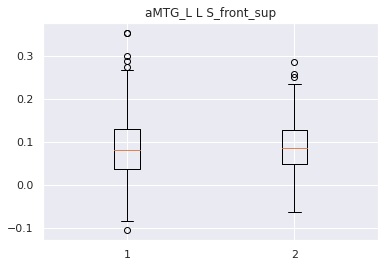

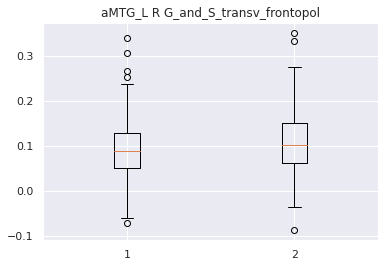

In [134]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(coef_logi["acc_test"], pvalue_logi, boot_coefs, rois, label, x_correl_logi)
bestRegion(ROIs)

## Best region for aMTG_L

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 935715.57it/s]

train: 456 test: 114


[array([0.73913043, 0.69565217, 0.63043478, 0.63043478, 0.80434783,
       0.7173913 , 0.8       , 0.84444444, 0.75555556, 0.57777778])]
predicted class  Femme  Homme
actual class                 
Femme               55      6
Homme               22     31
accuracy test (r2) = 0.7543859649122807
accuracy train (r2) = 0.7675438596491229
     coefficient    seed                      labels
98      0.141511  aMTG_L      R G_pariet_inf-Angular
78      0.130485  aMTG_L  R G_and_S_transv_frontopol
4       0.121897  aMTG_L  L G_and_S_transv_frontopol
135     0.112955  aMTG_L         R S_orbital_lateral
128     0.104403  aMTG_L      R S_interm_prim-Jensen
53      0.088668  aMTG_L               L S_front_sup
112     0.085543  aMTG_L      R Lat_Fis-ant-Horizont
127     0.078727  aMTG_L               R S_front_sup
74      0.073346  aMTG_L      R G_and_S_frontomargin
64      0.072532  aMTG_L       L S_parieto_occipital
The mean accuracy : 0.7543859649122807
The standard deviation of the accuracy :

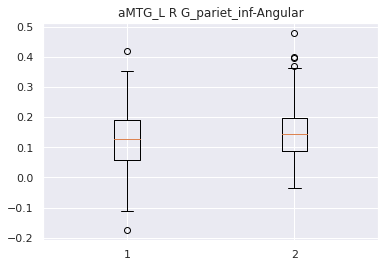

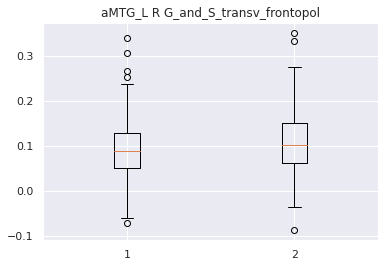

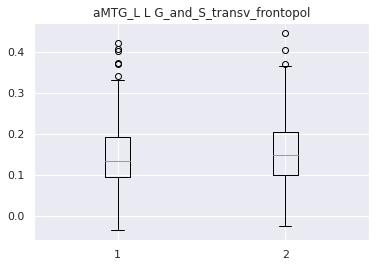

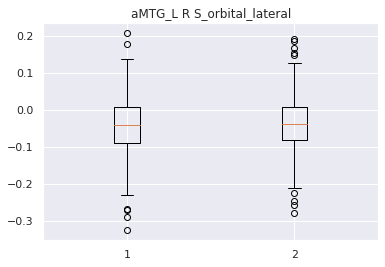

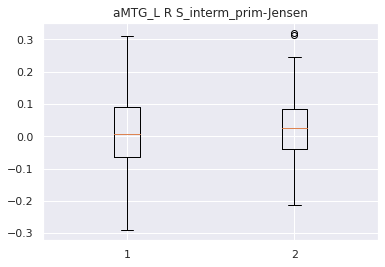

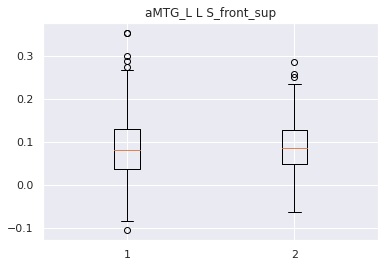

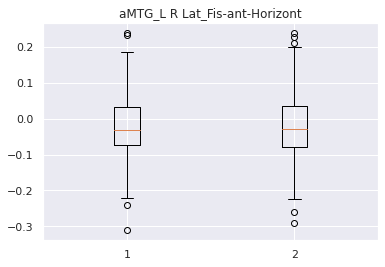

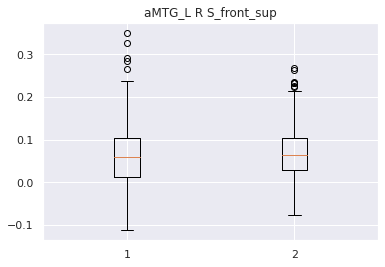

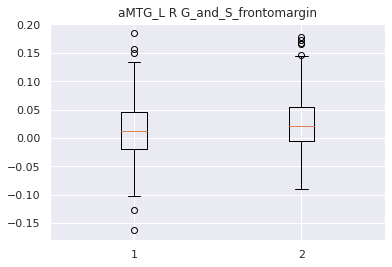

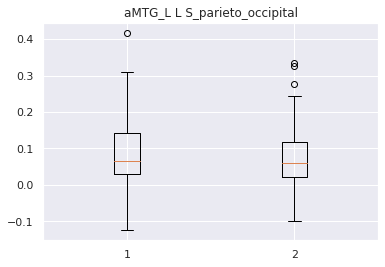

In [141]:
bootstrap_coef = []
SEEDS = ["aMTG_L"]
        
[x_correl_logi, coef_logi] = run_logistic(df_boot, data, SEEDS)

boot_coefs = (coef_logi["model"].coef_[0])

moyenne_logi = np.mean(boot_coefs, axis=0)
scoresZ_logi = (boot_coefs - moyenne_logi)/np.std(boot_coefs, axis=0)
assert np.sum(np.isnan(scoresZ_logi)) == 0
pvalue_logi = 2 * (1 - stats.norm.cdf(np.abs(scoresZ_logi)))

rois = ["aMTG_L"] # modified to rois of interest
ROIs = regionsOfInterest(coef_logi["acc_test"], pvalue_logi, boot_coefs, rois, label, x_correl_logi)
bestRegion(ROIs)

## Best region for aMTG_R

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 739255.81it/s]


train: 456 test: 114
[array([0.67391304, 0.69565217, 0.58695652, 0.65217391, 0.65217391,
       0.73913043, 0.8       , 0.73333333, 0.64444444, 0.66666667])]
predicted class  Femme  Homme
actual class                 
Femme               55      6
Homme               28     25
accuracy test (r2) = 0.7017543859649122
accuracy train (r2) = 0.7346491228070176
     coefficient    seed                      labels
78      0.110149  aMTG_R  R G_and_S_transv_frontopol
4       0.108504  aMTG_R  L G_and_S_transv_frontopol
135     0.100901  aMTG_R         R S_orbital_lateral
53      0.096193  aMTG_R               L S_front_sup
127     0.093951  aMTG_R               R S_front_sup
98      0.088630  aMTG_R      R G_pariet_inf-Angular
83      0.083330  aMTG_R     R G_cingul-Post-ventral
112     0.078210  aMTG_R      R Lat_Fis-ant-Horizont
64      0.071190  aMTG_R       L S_parieto_occipital
66      0.070564  aMTG_R             L S_postcentral
The mean accuracy : 0.7017543859649122
The standard deviat

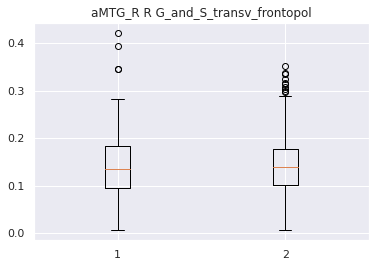

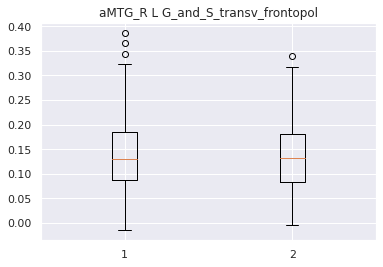

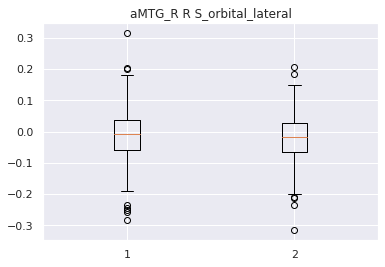

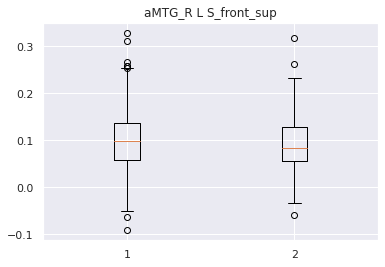

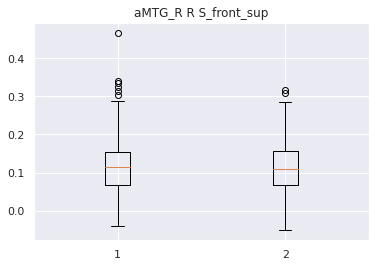

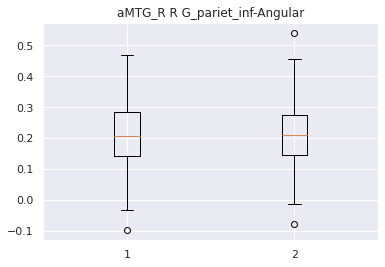

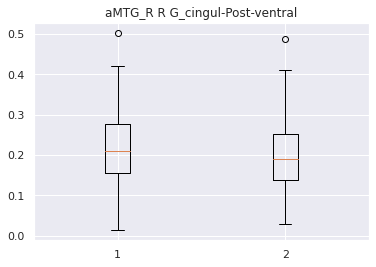

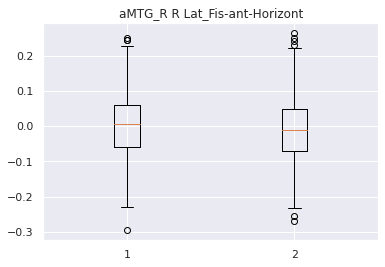

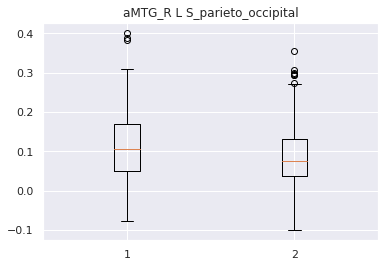

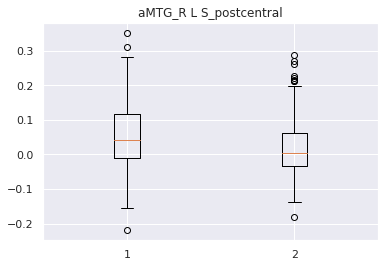

In [142]:
bootstrap_coef = []
SEEDS = ["aMTG_R"]
        
[x_correl_logi, coef_logi] = run_logistic(df_boot, data, SEEDS)

boot_coefs = (coef_logi["model"].coef_[0])

moyenne_logi = np.mean(boot_coefs, axis=0)
scoresZ_logi = (boot_coefs - moyenne_logi)/np.std(boot_coefs, axis=0)
assert np.sum(np.isnan(scoresZ_logi)) == 0
pvalue_logi = 2 * (1 - stats.norm.cdf(np.abs(scoresZ_logi)))

rois = ["aMTG_R"] # modified to rois of interest
ROIs = regionsOfInterest(coef_logi["acc_test"], pvalue_logi, boot_coefs, rois, label, x_correl_logi)
bestRegion(ROIs)

## Best region for opIFG_L

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 696809.47it/s]


train: 456 test: 114
[array([0.7173913 , 0.86956522, 0.63043478, 0.69565217, 0.82608696,
       0.67391304, 0.71111111, 0.75555556, 0.75555556, 0.71111111])]
predicted class  Femme  Homme
actual class                 
Femme               51     10
Homme               15     38
accuracy test (r2) = 0.7807017543859649
accuracy train (r2) = 0.7587719298245614
     coefficient     seed                   labels
41      0.110643  opIFG_L         L Pole_occipital
1       0.099984  opIFG_L  L G_and_S_occipital_inf
43      0.080261  opIFG_L            L S_calcarine
20      0.077350  opIFG_L  L G_oc-temp_lat-fusifor
84      0.068492  opIFG_L               R G_cuneus
21      0.064704  opIFG_L  L G_oc-temp_med-Lingual
124     0.063355  opIFG_L   R S_collat_transv_post
40      0.061452  opIFG_L           L Lat_Fis-post
89      0.061312  opIFG_L            R G_front_sup
125     0.059516  opIFG_L            R S_front_inf
The mean accuracy : 0.7807017543859649
The standard deviation of the accuracy : 

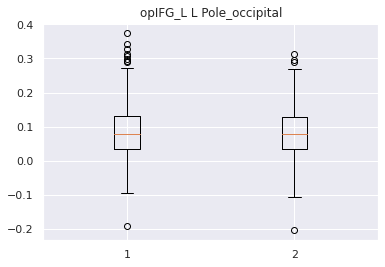

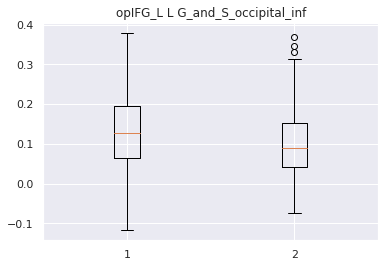

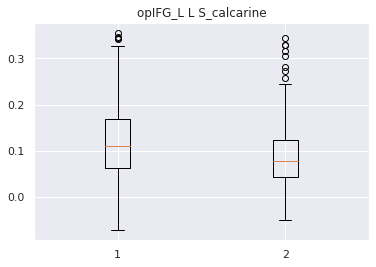

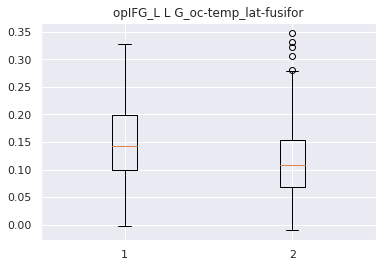

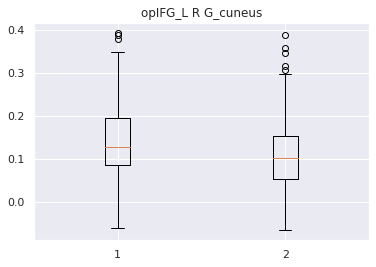

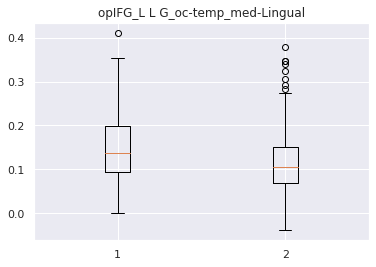

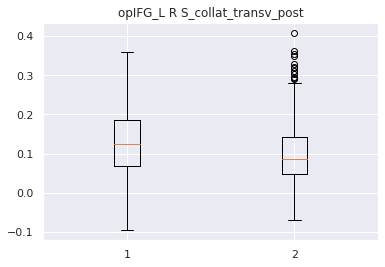

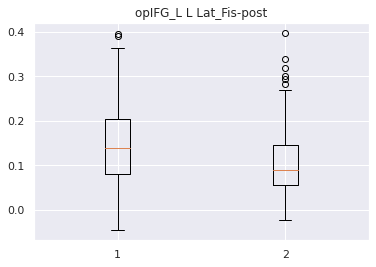

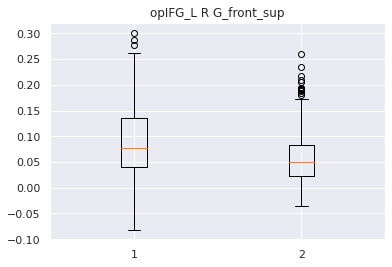

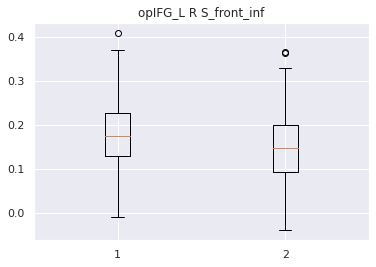

In [143]:
bootstrap_coef = []
SEEDS = ["opIFG_L"]
        
[x_correl_logi, coef_logi] = run_logistic(df_boot, data, SEEDS)

boot_coefs = (coef_logi["model"].coef_[0])

moyenne_logi = np.mean(boot_coefs, axis=0)
scoresZ_logi = (boot_coefs - moyenne_logi)/np.std(boot_coefs, axis=0)
assert np.sum(np.isnan(scoresZ_logi)) == 0
pvalue_logi = 2 * (1 - stats.norm.cdf(np.abs(scoresZ_logi)))

rois = ["opIFG_L"] # modified to rois of interest
ROIs = regionsOfInterest(coef_logi["acc_test"], pvalue_logi, boot_coefs, rois, label, x_correl_logi)
bestRegion(ROIs)

## Best region for opIFG_R

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 819874.24it/s]


train: 456 test: 114
[array([0.67391304, 0.76086957, 0.76086957, 0.69565217, 0.7173913 ,
       0.69565217, 0.8       , 0.77777778, 0.82222222, 0.64444444])]
predicted class  Femme  Homme
actual class                 
Femme               50     11
Homme               20     33
accuracy test (r2) = 0.7280701754385965
accuracy train (r2) = 0.7587719298245614
     coefficient     seed                       labels
43      0.093366  opIFG_R                L S_calcarine
20      0.088781  opIFG_R      L G_oc-temp_lat-fusifor
60      0.088020  opIFG_R  L S_oc-temp_med_and_Lingual
90      0.078446  opIFG_R    R G_Ins_lg_and_S_cent_ins
21      0.075507  opIFG_R      L G_oc-temp_med-Lingual
121     0.074148  opIFG_R      R S_circular_insula_inf
63      0.072867  opIFG_R         L S_orbital-H_Shaped
41      0.071447  opIFG_R             L Pole_occipital
124     0.069345  opIFG_R       R S_collat_transv_post
125     0.068376  opIFG_R                R S_front_inf
The mean accuracy : 0.72807017543859

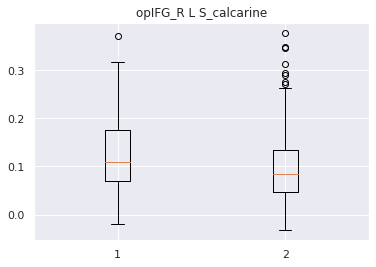

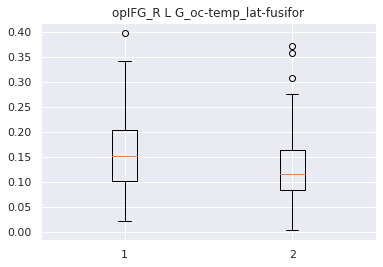

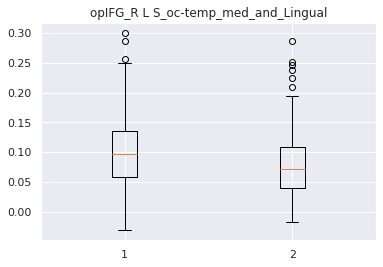

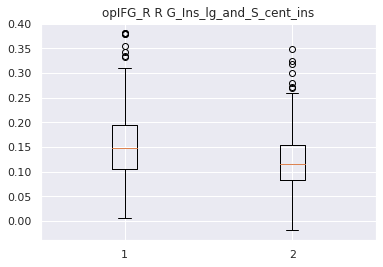

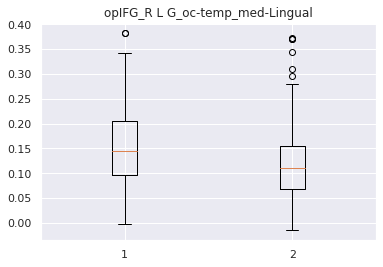

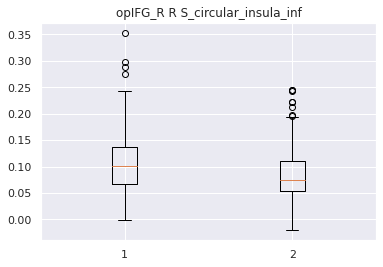

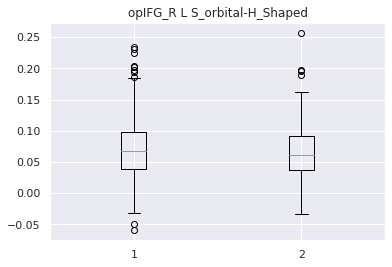

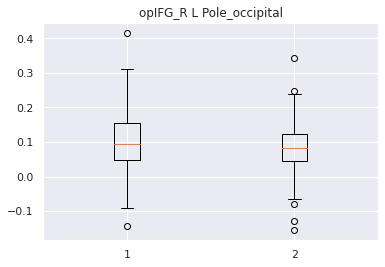

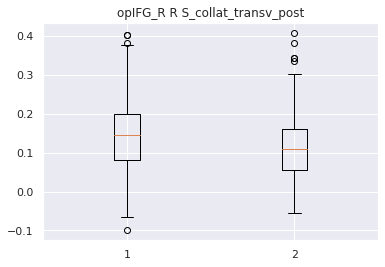

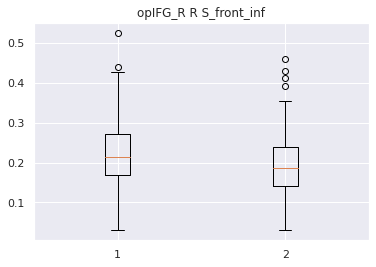

In [144]:
bootstrap_coef = []
SEEDS = ["opIFG_R"]
        
[x_correl_logi, coef_logi] = run_logistic(df_boot, data, SEEDS)

boot_coefs = (coef_logi["model"].coef_[0])

moyenne_logi = np.mean(boot_coefs, axis=0)
scoresZ_logi = (boot_coefs - moyenne_logi)/np.std(boot_coefs, axis=0)
assert np.sum(np.isnan(scoresZ_logi)) == 0
pvalue_logi = 2 * (1 - stats.norm.cdf(np.abs(scoresZ_logi)))

rois = ["opIFG_R"] # modified to rois of interest
ROIs = regionsOfInterest(coef_logi["acc_test"], pvalue_logi, boot_coefs, rois, label, x_correl_logi)
bestRegion(ROIs)

## Best region for pITG_L

100%|████████████████████████████████████| 570/570 [00:00<00:00, 1593835.52it/s]


train: 456 test: 114
[array([0.7173913 , 0.73913043, 0.63043478, 0.67391304, 0.7826087 ,
       0.69565217, 0.66666667, 0.64444444, 0.68888889, 0.66666667])]
predicted class  Femme  Homme
actual class                 
Femme               48     13
Homme               17     36
accuracy test (r2) = 0.7368421052631579
accuracy train (r2) = 0.7280701754385965
     coefficient    seed                       labels
9       0.131148  pITG_L      L G_cingul-Post-ventral
83      0.114869  pITG_L      R G_cingul-Post-ventral
66      0.094216  pITG_L              L S_postcentral
26      0.091353  pITG_L             L G_parietal_sup
115     0.090202  pITG_L             R Pole_occipital
55      0.075450  pITG_L  L S_intrapariet_and_P_trans
4       0.071896  pITG_L   L G_and_S_transv_frontopol
41      0.070649  pITG_L             L Pole_occipital
86      0.068458  pITG_L        R G_front_inf-Orbital
135     0.063434  pITG_L          R S_orbital_lateral
The mean accuracy : 0.7368421052631579
The stan

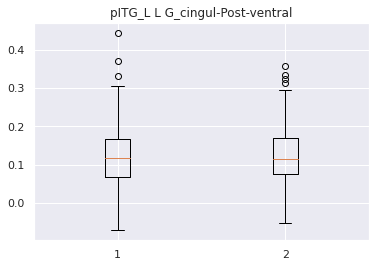

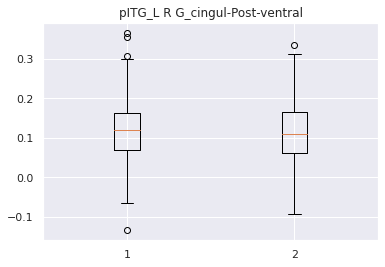

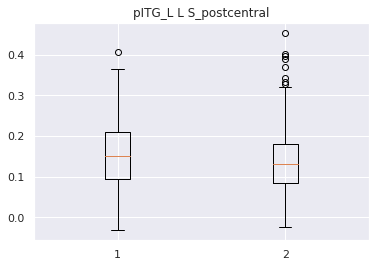

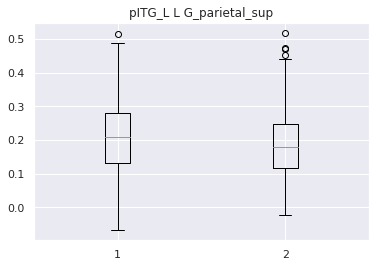

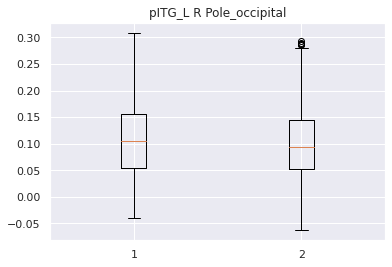

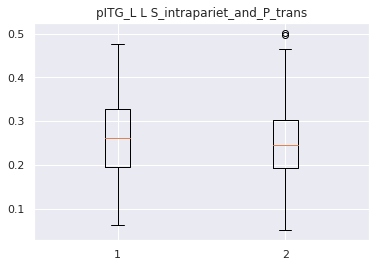

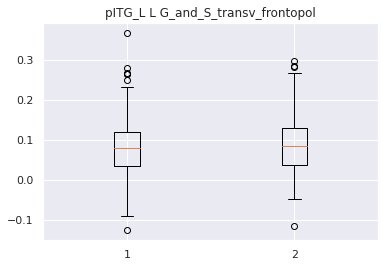

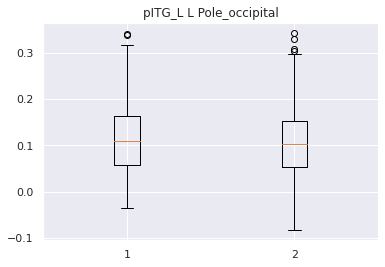

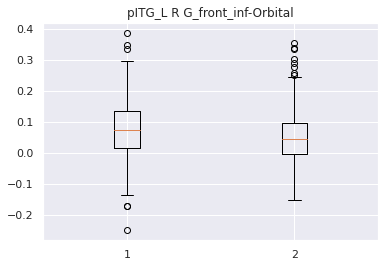

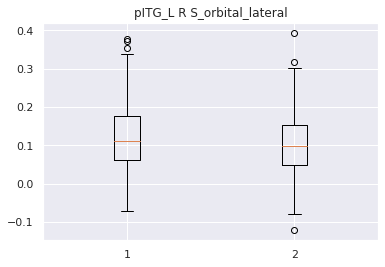

In [148]:
bootstrap_coef = []
SEEDS = ["pITG_L"]
        
[x_correl_logi, coef_logi] = run_logistic(df_boot, data, SEEDS)

boot_coefs = (coef_logi["model"].coef_[0])

moyenne_logi = np.mean(boot_coefs, axis=0)
scoresZ_logi = (boot_coefs - moyenne_logi)/np.std(boot_coefs, axis=0)
assert np.sum(np.isnan(scoresZ_logi)) == 0
pvalue_logi = 2 * (1 - stats.norm.cdf(np.abs(scoresZ_logi)))

rois = ["pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(coef_logi["acc_test"], pvalue_logi, boot_coefs, rois, label, x_correl_logi)
bestRegion(ROIs)

## Best region for pITG_R

100%|████████████████████████████████████| 570/570 [00:00<00:00, 1301444.35it/s]


train: 456 test: 114
[array([0.73913043, 0.63043478, 0.73913043, 0.60869565, 0.7173913 ,
       0.65217391, 0.68888889, 0.71111111, 0.73333333, 0.57777778])]
predicted class  Femme  Homme
actual class                 
Femme               47     14
Homme               16     37
accuracy test (r2) = 0.7368421052631579
accuracy train (r2) = 0.7412280701754386
     coefficient    seed                     labels
20      0.130722  pITG_R    L G_oc-temp_lat-fusifor
83      0.112035  pITG_R    R G_cingul-Post-ventral
9       0.098593  pITG_R    L G_cingul-Post-ventral
41      0.096544  pITG_R           L Pole_occipital
125     0.095350  pITG_R              R S_front_inf
59      0.087601  pITG_R            L S_oc-temp_lat
84      0.087539  pITG_R                 R G_cuneus
66      0.073944  pITG_R            L S_postcentral
21      0.067437  pITG_R    L G_oc-temp_med-Lingual
90      0.062689  pITG_R  R G_Ins_lg_and_S_cent_ins
The mean accuracy : 0.7368421052631579
The standard deviation of the 

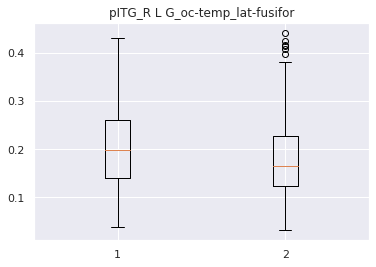

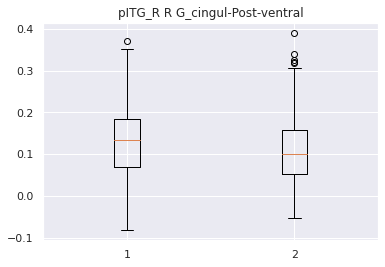

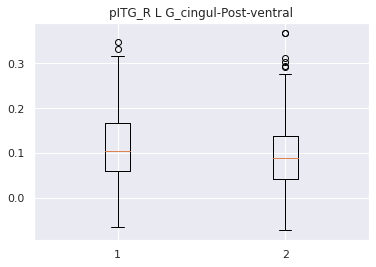

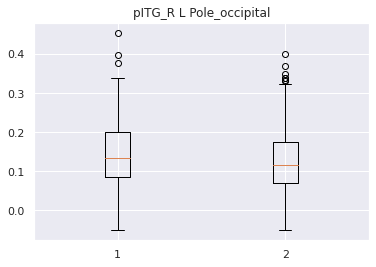

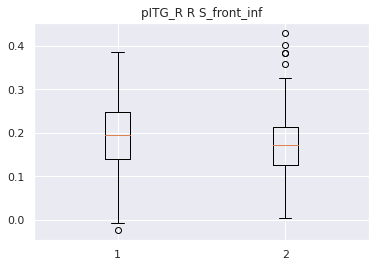

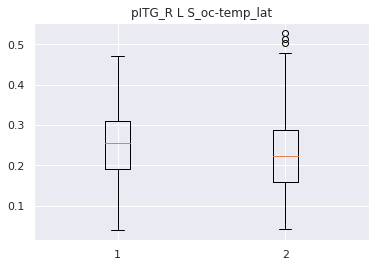

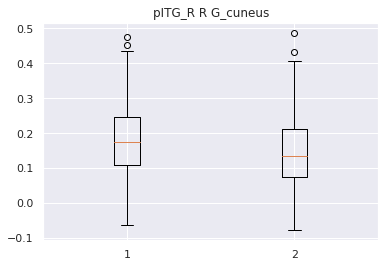

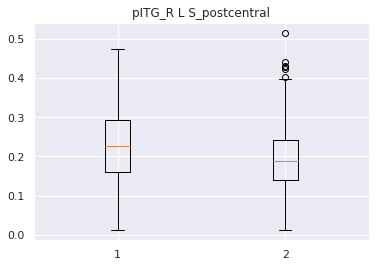

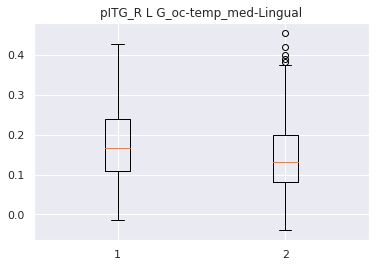

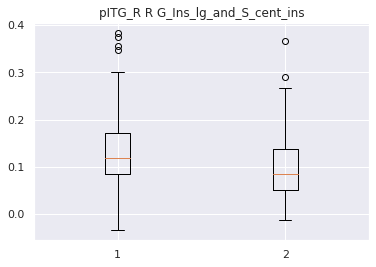

In [149]:
bootstrap_coef = []
SEEDS = ["pITG_R"]
        
[x_correl_logi, coef_logi] = run_logistic(df_boot, data, SEEDS)

boot_coefs = (coef_logi["model"].coef_[0])

moyenne_logi = np.mean(boot_coefs, axis=0)
scoresZ_logi = (boot_coefs - moyenne_logi)/np.std(boot_coefs, axis=0)
assert np.sum(np.isnan(scoresZ_logi)) == 0
pvalue_logi = 2 * (1 - stats.norm.cdf(np.abs(scoresZ_logi)))

rois = ["pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(coef_logi["acc_test"], pvalue_logi, boot_coefs, rois, label, x_correl_logi)
bestRegion(ROIs)

## Best region for planumtemp_L

100%|████████████████████████████████████| 570/570 [00:00<00:00, 1352236.02it/s]


train: 456 test: 114
[array([0.65217391, 0.80434783, 0.65217391, 0.7173913 , 0.73913043,
       0.69565217, 0.75555556, 0.73333333, 0.77777778, 0.6       ])]
predicted class  Femme  Homme
actual class                 
Femme               48     13
Homme               17     36
accuracy test (r2) = 0.7368421052631579
accuracy train (r2) = 0.743421052631579
     coefficient          seed                       labels
60      0.134138  planumtemp_L  L S_oc-temp_med_and_Lingual
43      0.132165  planumtemp_L                L S_calcarine
94      0.123957  planumtemp_L      R G_oc-temp_lat-fusifor
124     0.118118  planumtemp_L       R S_collat_transv_post
21      0.118071  planumtemp_L      L G_oc-temp_med-Lingual
20      0.117396  planumtemp_L      L G_oc-temp_lat-fusifor
84      0.098534  planumtemp_L                   R G_cuneus
16      0.087499  planumtemp_L    L G_Ins_lg_and_S_cent_ins
90      0.086927  planumtemp_L    R G_Ins_lg_and_S_cent_ins
95      0.082094  planumtemp_L      R G_oc

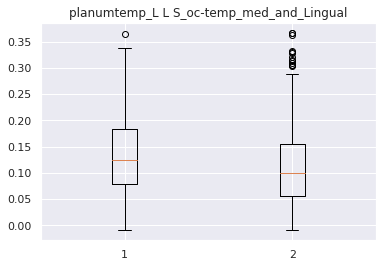

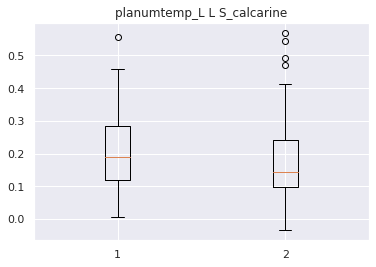

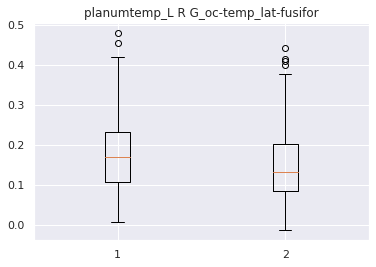

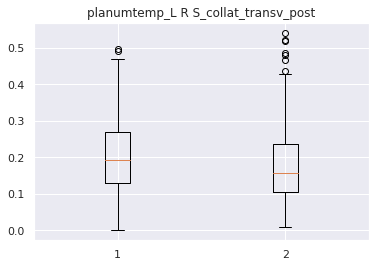

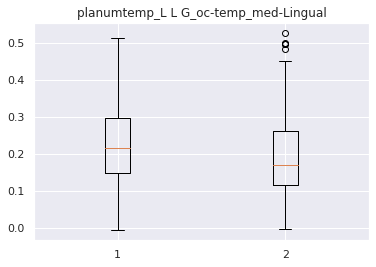

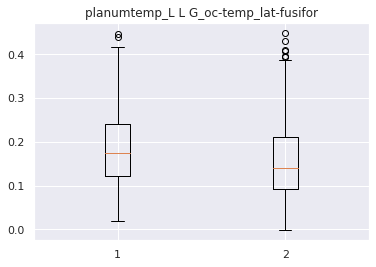

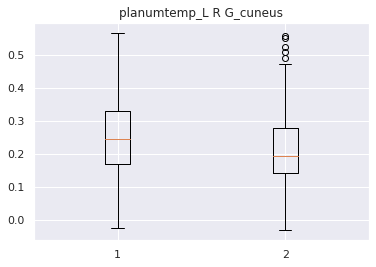

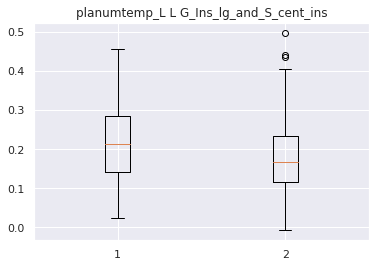

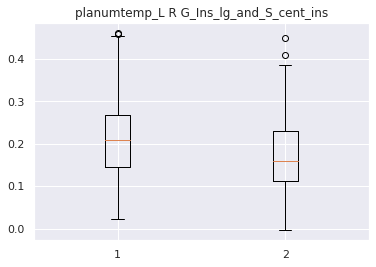

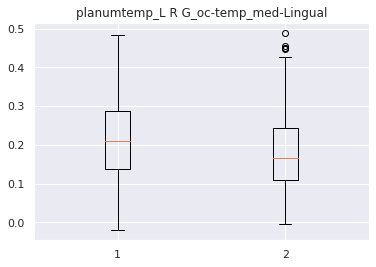

In [150]:
bootstrap_coef = []
SEEDS = ["planumtemp_L"]
        
[x_correl_logi, coef_logi] = run_logistic(df_boot, data, SEEDS)

boot_coefs = (coef_logi["model"].coef_[0])

moyenne_logi = np.mean(boot_coefs, axis=0)
scoresZ_logi = (boot_coefs - moyenne_logi)/np.std(boot_coefs, axis=0)
assert np.sum(np.isnan(scoresZ_logi)) == 0
pvalue_logi = 2 * (1 - stats.norm.cdf(np.abs(scoresZ_logi)))

rois = ["planumtemp_L"] # modified to rois of interest
ROIs = regionsOfInterest(coef_logi["acc_test"], pvalue_logi, boot_coefs, rois, label, x_correl_logi)
bestRegion(ROIs)

## Best region for planumtemp_R

100%|████████████████████████████████████| 570/570 [00:00<00:00, 1356840.68it/s]


train: 456 test: 114
[array([0.63043478, 0.7826087 , 0.67391304, 0.69565217, 0.67391304,
       0.65217391, 0.71111111, 0.66666667, 0.75555556, 0.6       ])]
predicted class  Femme  Homme
actual class                 
Femme               51     10
Homme               23     30
accuracy test (r2) = 0.7105263157894737
accuracy train (r2) = 0.7412280701754386
     coefficient          seed                       labels
43      0.126027  planumtemp_R                L S_calcarine
60      0.110963  planumtemp_R  L S_oc-temp_med_and_Lingual
72      0.098477  planumtemp_R             L S_temporal_sup
58      0.084294  planumtemp_R            L S_occipital_ant
78      0.083424  planumtemp_R   R G_and_S_transv_frontopol
21      0.081631  planumtemp_R      L G_oc-temp_med-Lingual
20      0.078635  planumtemp_R      L G_oc-temp_lat-fusifor
121     0.073895  planumtemp_R      R S_circular_insula_inf
94      0.073754  planumtemp_R      R G_oc-temp_lat-fusifor
47      0.073270  planumtemp_R      L S_c

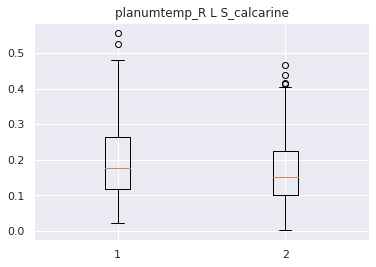

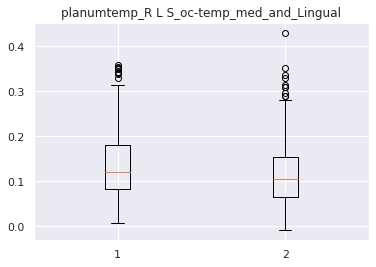

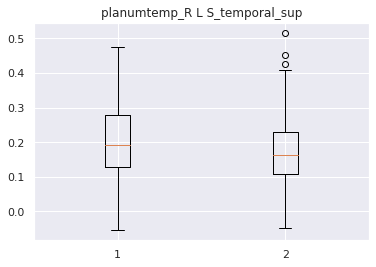

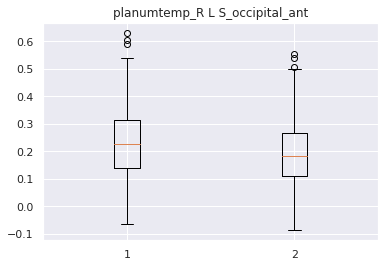

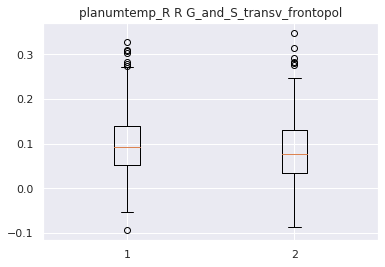

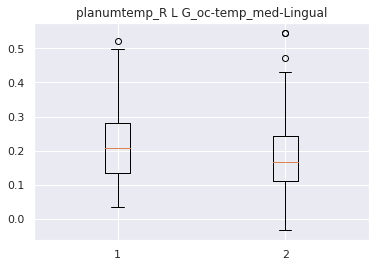

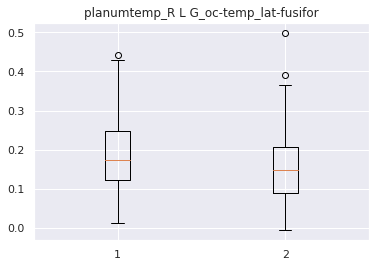

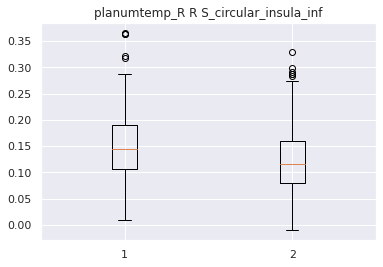

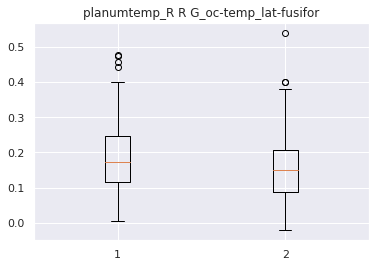

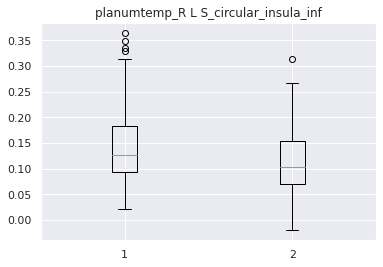

In [151]:
bootstrap_coef = []
SEEDS = ["planumtemp_R"]
        
[x_correl_logi, coef_logi] = run_logistic(df_boot, data, SEEDS)

boot_coefs = (coef_logi["model"].coef_[0])

moyenne_logi = np.mean(boot_coefs, axis=0)
scoresZ_logi = (boot_coefs - moyenne_logi)/np.std(boot_coefs, axis=0)
assert np.sum(np.isnan(scoresZ_logi)) == 0
pvalue_logi = 2 * (1 - stats.norm.cdf(np.abs(scoresZ_logi)))

rois = ["planumtemp_R"] # modified to rois of interest
ROIs = regionsOfInterest(coef_logi["acc_test"], pvalue_logi, boot_coefs, rois, label, x_correl_logi)
bestRegion(ROIs)

## Best region for all seed left

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 746643.75it/s]


train: 456 test: 114
[array([0.76086957, 0.89130435, 0.69565217, 0.80434783, 0.91304348,
       0.73913043, 0.8       , 0.8       , 0.86666667, 0.71111111])]
predicted class  Femme  Homme
actual class                 
Femme               53      8
Homme               10     43
accuracy test (r2) = 0.8421052631578947
accuracy train (r2) = 0.8837719298245614
     coefficient          seed                       labels
394     0.126003        aMTG_L       R G_pariet_inf-Angular
453     0.111245        pITG_L      L G_cingul-Post-ventral
300     0.110697        aMTG_L   L G_and_S_transv_frontopol
374     0.103060        aMTG_L   R G_and_S_transv_frontopol
431     0.099466        aMTG_L          R S_orbital_lateral
527     0.096244        pITG_L      R G_cingul-Post-ventral
41      0.090828       opIFG_L             L Pole_occipital
349     0.088173        aMTG_L                L S_front_sup
408     0.086339        aMTG_L       R Lat_Fis-ant-Horizont
208     0.084911  planumtemp_L  L S_oc-te

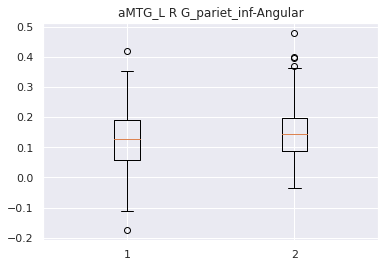

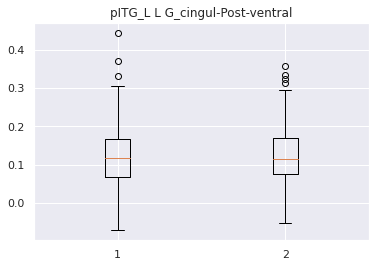

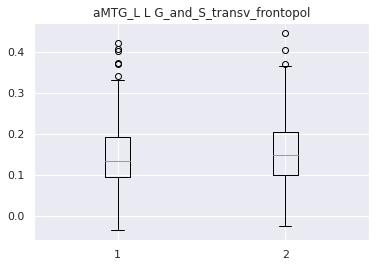

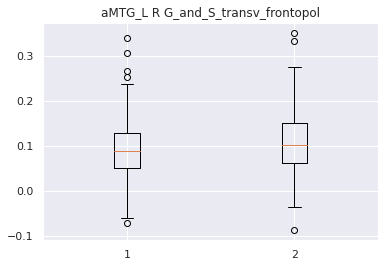

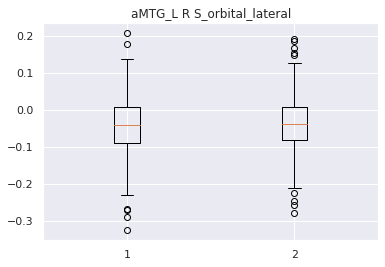

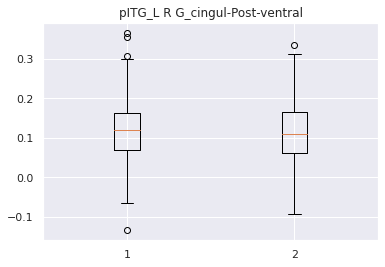

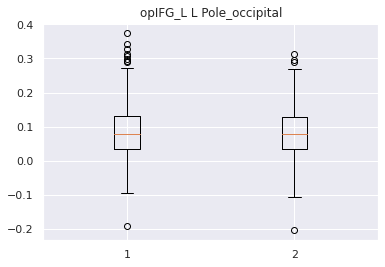

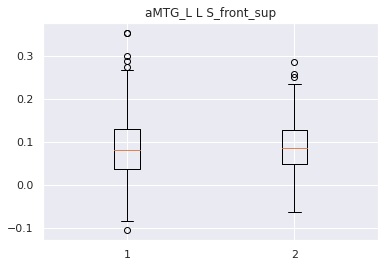

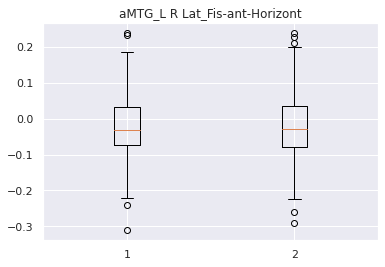

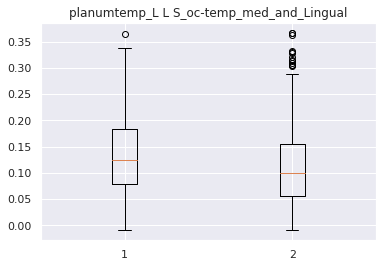

In [152]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"]
        
[x_correl_logi, coef_logi] = run_logistic(df_boot, data, SEEDS)

boot_coefs = (coef_logi["model"].coef_[0])

moyenne_logi = np.mean(boot_coefs, axis=0)
scoresZ_logi = (boot_coefs - moyenne_logi)/np.std(boot_coefs, axis=0)
assert np.sum(np.isnan(scoresZ_logi)) == 0
pvalue_logi = 2 * (1 - stats.norm.cdf(np.abs(scoresZ_logi)))

rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(coef_logi["acc_test"], pvalue_logi, boot_coefs, rois, label, x_correl_logi)
bestRegion(ROIs)

## Best region for all seed right

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 646848.83it/s]


train: 456 test: 114
[array([0.7173913 , 0.73913043, 0.7826087 , 0.7173913 , 0.7826087 ,
       0.76086957, 0.8       , 0.75555556, 0.91111111, 0.68888889])]
predicted class  Femme  Homme
actual class                 
Femme               52      9
Homme               15     38
accuracy test (r2) = 0.7894736842105263
accuracy train (r2) = 0.8991228070175439
     coefficient          seed                      labels
349     0.100059        aMTG_R               L S_front_sup
464     0.098680        pITG_R     L G_oc-temp_lat-fusifor
423     0.095451        aMTG_R               R S_front_sup
300     0.094796        aMTG_R  L G_and_S_transv_frontopol
431     0.092379        aMTG_R         R S_orbital_lateral
191     0.090771  planumtemp_R               L S_calcarine
569     0.090553        pITG_R               R S_front_inf
379     0.087632        aMTG_R     R G_cingul-Post-ventral
485     0.081025        pITG_R            L Pole_occipital
374     0.080787        aMTG_R  R G_and_S_transv_fr

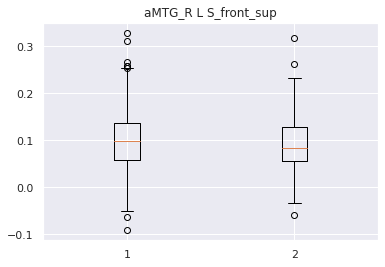

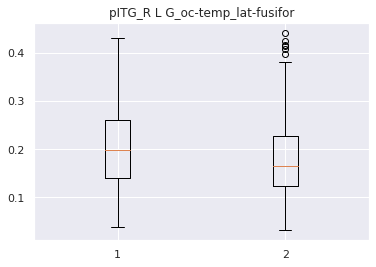

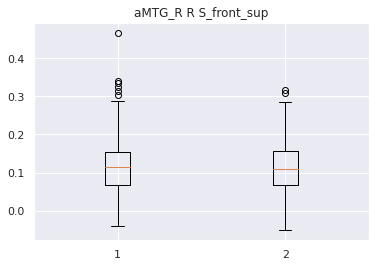

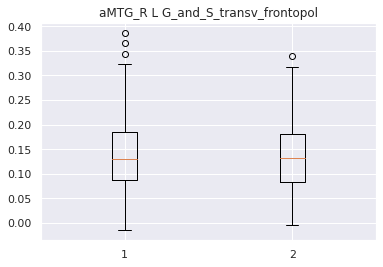

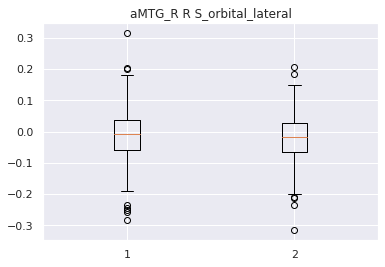

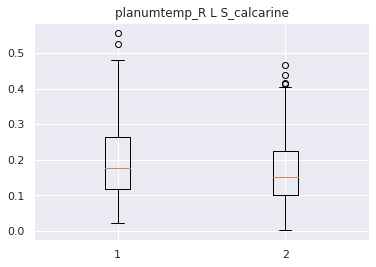

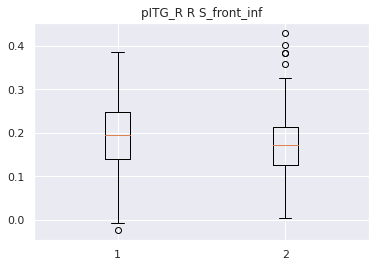

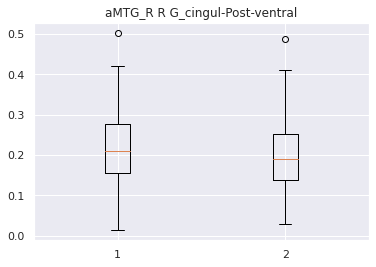

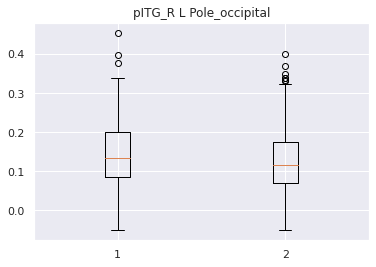

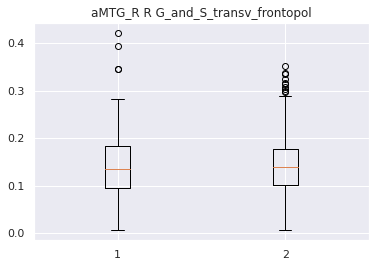

In [153]:
bootstrap_coef = []
SEEDS = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
        
[x_correl_logi, coef_logi] = run_logistic(df_boot, data, SEEDS)

boot_coefs = (coef_logi["model"].coef_[0])

moyenne_logi = np.mean(boot_coefs, axis=0)
scoresZ_logi = (boot_coefs - moyenne_logi)/np.std(boot_coefs, axis=0)
assert np.sum(np.isnan(scoresZ_logi)) == 0
pvalue_logi = 2 * (1 - stats.norm.cdf(np.abs(scoresZ_logi)))

rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(coef_logi["acc_test"], pvalue_logi, boot_coefs, rois, label, x_correl_logi)
bestRegion(ROIs)